# import statements

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import time
import pickle

from skimage.feature import hog
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML

from functions import *
from video_detector import *
from linearSVM import PegasosSVM


# Load Weights

In [15]:
w_l = np.loadtxt("svm.weights")

# Initialize detector

In [16]:
svc = PegasosSVM(weights=w_l)

# Initialize hyperparameters

In [17]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 4 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off

X_scaler = None

if hist_feat or spatial_feat:
    with open('x_scaler.pkl', 'rb') as f:
        X_scaler = pickle.load(f)


# End-to-End pipeline for vehicle detection on one image

In [18]:
def process_one_image(test_img):
    #test_img must be a numpy array
    predictions = []

    for scale in np.arange(1.0,3.5,0.5):
        ystart = int((test_img.shape[0]+(30*scale))/2)
        ystop = int(0.9*test_img.shape[0])
        curr_pred = find_cars(test_img, ystart, ystop, scale, svc, 
                              X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space)
        predictions += curr_pred
        
    # add detections to the history iff processing video file images
    if isinstance(detector, VehicleDetectVideo):
        if len(predictions) > 0:
            detector.addPreds(predictions)
     
    heat = np.zeros_like(test_img[:,:,0])
    
    thresh = 1
    if isinstance(detector, VehicleDetectVideo):
        # Add heat to each box in box list
        for pred_set in detector.prev_rects:
            heat = add_heat(heat,pred_set)
            thresh = 1 + len(detector.prev_rects)//2
    else:
        # Add heat to each box in box list
        heat = add_heat(heat,predictions)
        thresh = 1

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,thresh)
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    print('number of cars found:',labels[1])
    #draw final bounding boxes on a copy of the original image
    draw_img, final_predictions = draw_labeled_bboxes(np.copy(test_img), labels)
    
    return draw_img

# Test the pipleline on test images

number of cars found: 3
number of cars found: 0
number of cars found: 1
number of cars found: 5
number of cars found: 2
number of cars found: 2


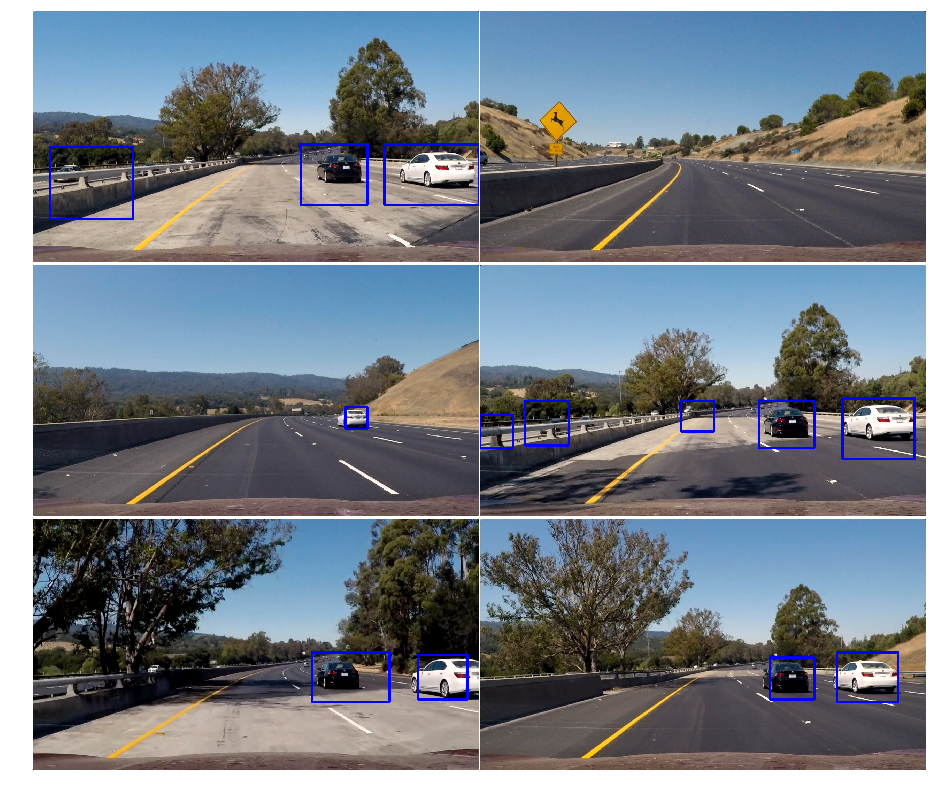

In [19]:
detector = None
test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    axs[i].imshow(process_one_image(mpimg.imread(im)))
    axs[i].axis('off')

# Test the pipleline on video 1

In [20]:
detector = VehicleDetectVideo(10)

test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(process_one_image)
%time clip_test_out.write_videofile(test_out_file, audio=False)
clip_test.reader.close()
clip_test.audio.reader.close_proc()
detector = None

number of cars found: 2
[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


  0%|                                                                                           | 0/39 [00:00<?, ?it/s]

number of cars found: 2


  3%|██▏                                                                                | 1/39 [00:01<00:49,  1.30s/it]

number of cars found: 2


  5%|████▎                                                                              | 2/39 [00:02<00:49,  1.33s/it]

number of cars found: 2


  8%|██████▍                                                                            | 3/39 [00:03<00:47,  1.33s/it]

number of cars found: 2


 10%|████████▌                                                                          | 4/39 [00:05<00:46,  1.33s/it]

number of cars found: 2


 13%|██████████▋                                                                        | 5/39 [00:06<00:45,  1.34s/it]

number of cars found: 2


 15%|████████████▊                                                                      | 6/39 [00:08<00:45,  1.39s/it]

number of cars found: 2


 18%|██████████████▉                                                                    | 7/39 [00:09<00:43,  1.37s/it]

number of cars found: 2


 21%|█████████████████                                                                  | 8/39 [00:10<00:41,  1.35s/it]

number of cars found: 2


 23%|███████████████████▏                                                               | 9/39 [00:12<00:40,  1.34s/it]

number of cars found: 2


 26%|█████████████████████                                                             | 10/39 [00:13<00:38,  1.34s/it]

number of cars found: 2


 28%|███████████████████████▏                                                          | 11/39 [00:14<00:37,  1.34s/it]

number of cars found: 2


 31%|█████████████████████████▏                                                        | 12/39 [00:15<00:35,  1.33s/it]

number of cars found: 2


 33%|███████████████████████████▎                                                      | 13/39 [00:17<00:34,  1.32s/it]

number of cars found: 2


 36%|█████████████████████████████▍                                                    | 14/39 [00:18<00:32,  1.31s/it]

number of cars found: 2


 38%|███████████████████████████████▌                                                  | 15/39 [00:19<00:31,  1.32s/it]

number of cars found: 2


 41%|█████████████████████████████████▋                                                | 16/39 [00:21<00:30,  1.32s/it]

number of cars found: 2


 44%|███████████████████████████████████▋                                              | 17/39 [00:22<00:29,  1.32s/it]

number of cars found: 2


 46%|█████████████████████████████████████▊                                            | 18/39 [00:23<00:27,  1.33s/it]

number of cars found: 2


 49%|███████████████████████████████████████▉                                          | 19/39 [00:25<00:26,  1.33s/it]

number of cars found: 2


 51%|██████████████████████████████████████████                                        | 20/39 [00:26<00:25,  1.33s/it]

number of cars found: 2


 54%|████████████████████████████████████████████▏                                     | 21/39 [00:27<00:23,  1.33s/it]

number of cars found: 2


 56%|██████████████████████████████████████████████▎                                   | 22/39 [00:29<00:22,  1.34s/it]

number of cars found: 2


 59%|████████████████████████████████████████████████▎                                 | 23/39 [00:31<00:21,  1.35s/it]

number of cars found: 2


 62%|██████████████████████████████████████████████████▍                               | 24/39 [00:32<00:20,  1.35s/it]

number of cars found: 2


 64%|████████████████████████████████████████████████████▌                             | 25/39 [00:33<00:19,  1.36s/it]

number of cars found: 2


 67%|██████████████████████████████████████████████████████▋                           | 26/39 [00:35<00:17,  1.36s/it]

number of cars found: 2


 69%|████████████████████████████████████████████████████████▊                         | 27/39 [00:37<00:16,  1.37s/it]

number of cars found: 2


 72%|██████████████████████████████████████████████████████████▊                       | 28/39 [00:38<00:15,  1.37s/it]

number of cars found: 2


 74%|████████████████████████████████████████████████████████████▉                     | 29/39 [00:39<00:13,  1.37s/it]

number of cars found: 2


 77%|███████████████████████████████████████████████████████████████                   | 30/39 [00:41<00:12,  1.37s/it]

number of cars found: 2


 79%|█████████████████████████████████████████████████████████████████▏                | 31/39 [00:42<00:10,  1.37s/it]

number of cars found: 2


 82%|███████████████████████████████████████████████████████████████████▎              | 32/39 [00:43<00:09,  1.37s/it]

number of cars found: 2


 85%|█████████████████████████████████████████████████████████████████████▍            | 33/39 [00:45<00:08,  1.36s/it]

number of cars found: 2


 87%|███████████████████████████████████████████████████████████████████████▍          | 34/39 [00:46<00:06,  1.36s/it]

number of cars found: 2


 90%|█████████████████████████████████████████████████████████████████████████▌        | 35/39 [00:47<00:05,  1.36s/it]

number of cars found: 2


 92%|███████████████████████████████████████████████████████████████████████████▋      | 36/39 [00:49<00:04,  1.36s/it]

number of cars found: 2


 95%|█████████████████████████████████████████████████████████████████████████████▊    | 37/39 [00:50<00:02,  1.36s/it]

number of cars found: 2


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:51<00:01,  1.36s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

Wall time: 52.7 s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out_file))

# Run Pipeline on video 2

In [22]:
detector = VehicleDetectVideo(10)

proj_out_file = 'project_video_out.mp4'
clip_proj = VideoFileClip('project_video.mp4')
clip_proj_out = clip_proj.fl_image(process_one_image)
%time clip_proj_out.write_videofile(proj_out_file, audio=False)
clip_proj.reader.close()
clip_proj.audio.reader.close_proc()

detector = None

number of cars found: 1
[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


  0%|                                                                                         | 0/1261 [00:00<?, ?it/s]

number of cars found: 1


  0%|                                                                                 | 1/1261 [00:01<29:57,  1.43s/it]

number of cars found: 1


  0%|▏                                                                                | 2/1261 [00:02<28:42,  1.37s/it]

number of cars found: 1


  0%|▏                                                                                | 3/1261 [00:04<28:07,  1.34s/it]

number of cars found: 1


  0%|▎                                                                                | 4/1261 [00:05<27:49,  1.33s/it]

number of cars found: 1


  0%|▎                                                                                | 5/1261 [00:06<27:37,  1.32s/it]

number of cars found: 1


  0%|▍                                                                                | 6/1261 [00:07<27:26,  1.31s/it]

number of cars found: 1


  1%|▍                                                                                | 7/1261 [00:09<27:27,  1.31s/it]

number of cars found: 1


  1%|▌                                                                                | 8/1261 [00:10<27:19,  1.31s/it]

number of cars found: 1


  1%|▌                                                                                | 9/1261 [00:11<27:07,  1.30s/it]

number of cars found: 1


  1%|▋                                                                               | 10/1261 [00:12<27:01,  1.30s/it]

number of cars found: 1


  1%|▋                                                                               | 11/1261 [00:14<26:58,  1.29s/it]

number of cars found: 1


  1%|▊                                                                               | 12/1261 [00:15<26:58,  1.30s/it]

number of cars found: 1


  1%|▊                                                                               | 13/1261 [00:16<26:50,  1.29s/it]

number of cars found: 1


  1%|▉                                                                               | 14/1261 [00:18<26:47,  1.29s/it]

number of cars found: 1


  1%|▉                                                                               | 15/1261 [00:19<26:42,  1.29s/it]

number of cars found: 1


  1%|█                                                                               | 16/1261 [00:20<26:41,  1.29s/it]

number of cars found: 1


  1%|█                                                                               | 17/1261 [00:21<26:37,  1.28s/it]

number of cars found: 1


  1%|█▏                                                                              | 18/1261 [00:23<26:39,  1.29s/it]

number of cars found: 1


  2%|█▏                                                                              | 19/1261 [00:24<26:38,  1.29s/it]

number of cars found: 1


  2%|█▎                                                                              | 20/1261 [00:25<26:35,  1.29s/it]

number of cars found: 1


  2%|█▎                                                                              | 21/1261 [00:27<26:35,  1.29s/it]

number of cars found: 1


  2%|█▍                                                                              | 22/1261 [00:28<26:35,  1.29s/it]

number of cars found: 1


  2%|█▍                                                                              | 23/1261 [00:29<26:36,  1.29s/it]

number of cars found: 1


  2%|█▌                                                                              | 24/1261 [00:30<26:37,  1.29s/it]

number of cars found: 1


  2%|█▌                                                                              | 25/1261 [00:32<26:33,  1.29s/it]

number of cars found: 1


  2%|█▋                                                                              | 26/1261 [00:33<26:27,  1.29s/it]

number of cars found: 1


  2%|█▋                                                                              | 27/1261 [00:34<26:25,  1.28s/it]

number of cars found: 1


  2%|█▊                                                                              | 28/1261 [00:35<26:24,  1.28s/it]

number of cars found: 1


  2%|█▊                                                                              | 29/1261 [00:37<26:16,  1.28s/it]

number of cars found: 1


  2%|█▉                                                                              | 30/1261 [00:38<26:09,  1.28s/it]

number of cars found: 1


  2%|█▉                                                                              | 31/1261 [00:39<26:05,  1.27s/it]

number of cars found: 1


  3%|██                                                                              | 32/1261 [00:40<25:59,  1.27s/it]

number of cars found: 1


  3%|██                                                                              | 33/1261 [00:41<25:57,  1.27s/it]

number of cars found: 1


  3%|██▏                                                                             | 34/1261 [00:43<25:53,  1.27s/it]

number of cars found: 1


  3%|██▏                                                                             | 35/1261 [00:44<25:51,  1.27s/it]

number of cars found: 1


  3%|██▎                                                                             | 36/1261 [00:45<25:52,  1.27s/it]

number of cars found: 1


  3%|██▎                                                                             | 37/1261 [00:46<25:51,  1.27s/it]

number of cars found: 1


  3%|██▍                                                                             | 38/1261 [00:48<25:51,  1.27s/it]

number of cars found: 1


  3%|██▍                                                                             | 39/1261 [00:49<25:53,  1.27s/it]

number of cars found: 1


  3%|██▌                                                                             | 40/1261 [00:50<25:54,  1.27s/it]

number of cars found: 1


  3%|██▌                                                                             | 41/1261 [00:52<25:49,  1.27s/it]

number of cars found: 1


  3%|██▋                                                                             | 42/1261 [00:53<25:46,  1.27s/it]

number of cars found: 1


  3%|██▋                                                                             | 43/1261 [00:54<25:48,  1.27s/it]

number of cars found: 1


  3%|██▊                                                                             | 44/1261 [00:56<25:50,  1.27s/it]

number of cars found: 1


  4%|██▊                                                                             | 45/1261 [00:57<25:50,  1.28s/it]

number of cars found: 1


  4%|██▉                                                                             | 46/1261 [00:58<25:47,  1.27s/it]

number of cars found: 1


  4%|██▉                                                                             | 47/1261 [00:59<25:49,  1.28s/it]

number of cars found: 1


  4%|███                                                                             | 48/1261 [01:01<25:47,  1.28s/it]

number of cars found: 1


  4%|███                                                                             | 49/1261 [01:02<25:45,  1.27s/it]

number of cars found: 1


  4%|███▏                                                                            | 50/1261 [01:03<25:44,  1.28s/it]

number of cars found: 1


  4%|███▏                                                                            | 51/1261 [01:05<25:44,  1.28s/it]

number of cars found: 1


  4%|███▎                                                                            | 52/1261 [01:06<25:46,  1.28s/it]

number of cars found: 1


  4%|███▎                                                                            | 53/1261 [01:07<25:45,  1.28s/it]

number of cars found: 1


  4%|███▍                                                                            | 54/1261 [01:09<25:44,  1.28s/it]

number of cars found: 1


  4%|███▍                                                                            | 55/1261 [01:10<25:45,  1.28s/it]

number of cars found: 1


  4%|███▌                                                                            | 56/1261 [01:11<25:45,  1.28s/it]

number of cars found: 1


  5%|███▌                                                                            | 57/1261 [01:13<25:46,  1.28s/it]

number of cars found: 1


  5%|███▋                                                                            | 58/1261 [01:14<25:44,  1.28s/it]

number of cars found: 1


  5%|███▋                                                                            | 59/1261 [01:15<25:43,  1.28s/it]

number of cars found: 1


  5%|███▊                                                                            | 60/1261 [01:17<25:41,  1.28s/it]

number of cars found: 1


  5%|███▊                                                                            | 61/1261 [01:18<25:43,  1.29s/it]

number of cars found: 1


  5%|███▉                                                                            | 62/1261 [01:19<25:45,  1.29s/it]

number of cars found: 1


  5%|███▉                                                                            | 63/1261 [01:21<25:47,  1.29s/it]

number of cars found: 1


  5%|████                                                                            | 64/1261 [01:22<25:46,  1.29s/it]

number of cars found: 1


  5%|████                                                                            | 65/1261 [01:23<25:44,  1.29s/it]

number of cars found: 1


  5%|████▏                                                                           | 66/1261 [01:25<25:42,  1.29s/it]

number of cars found: 1


  5%|████▎                                                                           | 67/1261 [01:26<25:40,  1.29s/it]

number of cars found: 1


  5%|████▎                                                                           | 68/1261 [01:27<25:40,  1.29s/it]

number of cars found: 1


  5%|████▍                                                                           | 69/1261 [01:29<25:39,  1.29s/it]

number of cars found: 1


  6%|████▍                                                                           | 70/1261 [01:30<25:39,  1.29s/it]

number of cars found: 1


  6%|████▌                                                                           | 71/1261 [01:31<25:38,  1.29s/it]

number of cars found: 1


  6%|████▌                                                                           | 72/1261 [01:33<25:38,  1.29s/it]

number of cars found: 1


  6%|████▋                                                                           | 73/1261 [01:34<25:36,  1.29s/it]

number of cars found: 0


  6%|████▋                                                                           | 74/1261 [01:35<25:33,  1.29s/it]

number of cars found: 0


  6%|████▊                                                                           | 75/1261 [01:36<25:31,  1.29s/it]

number of cars found: 0


  6%|████▊                                                                           | 76/1261 [01:38<25:29,  1.29s/it]

number of cars found: 0


  6%|████▉                                                                           | 77/1261 [01:39<25:27,  1.29s/it]

number of cars found: 0


  6%|████▉                                                                           | 78/1261 [01:40<25:26,  1.29s/it]

number of cars found: 0


  6%|█████                                                                           | 79/1261 [01:41<25:24,  1.29s/it]

number of cars found: 0


  6%|█████                                                                           | 80/1261 [01:43<25:22,  1.29s/it]

number of cars found: 0


  6%|█████▏                                                                          | 81/1261 [01:44<25:20,  1.29s/it]

number of cars found: 0


  7%|█████▏                                                                          | 82/1261 [01:45<25:18,  1.29s/it]

number of cars found: 0


  7%|█████▎                                                                          | 83/1261 [01:46<25:16,  1.29s/it]

number of cars found: 0


  7%|█████▎                                                                          | 84/1261 [01:48<25:14,  1.29s/it]

number of cars found: 0


  7%|█████▍                                                                          | 85/1261 [01:49<25:12,  1.29s/it]

number of cars found: 0


  7%|█████▍                                                                          | 86/1261 [01:50<25:10,  1.29s/it]

number of cars found: 0


  7%|█████▌                                                                          | 87/1261 [01:51<25:08,  1.28s/it]

number of cars found: 0


  7%|█████▌                                                                          | 88/1261 [01:52<25:05,  1.28s/it]

number of cars found: 0


  7%|█████▋                                                                          | 89/1261 [01:54<25:03,  1.28s/it]

number of cars found: 0


  7%|█████▋                                                                          | 90/1261 [01:55<25:01,  1.28s/it]

number of cars found: 0


  7%|█████▊                                                                          | 91/1261 [01:56<24:58,  1.28s/it]

number of cars found: 0


  7%|█████▊                                                                          | 92/1261 [01:57<24:56,  1.28s/it]

number of cars found: 0


  7%|█████▉                                                                          | 93/1261 [01:58<24:53,  1.28s/it]

number of cars found: 0


  7%|█████▉                                                                          | 94/1261 [02:00<24:51,  1.28s/it]

number of cars found: 0


  8%|██████                                                                          | 95/1261 [02:01<24:52,  1.28s/it]

number of cars found: 0


  8%|██████                                                                          | 96/1261 [02:03<24:53,  1.28s/it]

number of cars found: 0


  8%|██████▏                                                                         | 97/1261 [02:04<24:53,  1.28s/it]

number of cars found: 0


  8%|██████▏                                                                         | 98/1261 [02:06<24:55,  1.29s/it]

number of cars found: 0


  8%|██████▎                                                                         | 99/1261 [02:07<24:58,  1.29s/it]

number of cars found: 0


  8%|██████▎                                                                        | 100/1261 [02:09<24:58,  1.29s/it]

number of cars found: 0


  8%|██████▎                                                                        | 101/1261 [02:10<24:57,  1.29s/it]

number of cars found: 0


  8%|██████▍                                                                        | 102/1261 [02:11<24:56,  1.29s/it]

number of cars found: 0


  8%|██████▍                                                                        | 103/1261 [02:12<24:55,  1.29s/it]

number of cars found: 0


  8%|██████▌                                                                        | 104/1261 [02:14<24:55,  1.29s/it]

number of cars found: 0


  8%|██████▌                                                                        | 105/1261 [02:15<24:53,  1.29s/it]

number of cars found: 0


  8%|██████▋                                                                        | 106/1261 [02:17<24:53,  1.29s/it]

number of cars found: 0


  8%|██████▋                                                                        | 107/1261 [02:18<24:53,  1.29s/it]

number of cars found: 0


  9%|██████▊                                                                        | 108/1261 [02:19<24:52,  1.29s/it]

number of cars found: 0


  9%|██████▊                                                                        | 109/1261 [02:21<24:54,  1.30s/it]

number of cars found: 0


  9%|██████▉                                                                        | 110/1261 [02:22<24:55,  1.30s/it]

number of cars found: 0


  9%|██████▉                                                                        | 111/1261 [02:24<24:55,  1.30s/it]

number of cars found: 0


  9%|███████                                                                        | 112/1261 [02:25<24:54,  1.30s/it]

number of cars found: 0


  9%|███████                                                                        | 113/1261 [02:27<24:53,  1.30s/it]

number of cars found: 1


  9%|███████▏                                                                       | 114/1261 [02:28<24:53,  1.30s/it]

number of cars found: 1


  9%|███████▏                                                                       | 115/1261 [02:29<24:52,  1.30s/it]

number of cars found: 1


  9%|███████▎                                                                       | 116/1261 [02:31<24:52,  1.30s/it]

number of cars found: 1


  9%|███████▎                                                                       | 117/1261 [02:32<24:52,  1.30s/it]

number of cars found: 1


  9%|███████▍                                                                       | 118/1261 [02:34<24:51,  1.31s/it]

number of cars found: 0


  9%|███████▍                                                                       | 119/1261 [02:35<24:50,  1.31s/it]

number of cars found: 0


 10%|███████▌                                                                       | 120/1261 [02:36<24:48,  1.30s/it]

number of cars found: 0


 10%|███████▌                                                                       | 121/1261 [02:37<24:47,  1.30s/it]

number of cars found: 0


 10%|███████▋                                                                       | 122/1261 [02:39<24:46,  1.31s/it]

number of cars found: 0


 10%|███████▋                                                                       | 123/1261 [02:40<24:45,  1.31s/it]

number of cars found: 0


 10%|███████▊                                                                       | 124/1261 [02:41<24:44,  1.31s/it]

number of cars found: 0


 10%|███████▊                                                                       | 125/1261 [02:43<24:45,  1.31s/it]

number of cars found: 0


 10%|███████▉                                                                       | 126/1261 [02:44<24:45,  1.31s/it]

number of cars found: 0


 10%|███████▉                                                                       | 127/1261 [02:46<24:44,  1.31s/it]

number of cars found: 0


 10%|████████                                                                       | 128/1261 [02:47<24:43,  1.31s/it]

number of cars found: 0


 10%|████████                                                                       | 129/1261 [02:48<24:41,  1.31s/it]

number of cars found: 0


 10%|████████▏                                                                      | 130/1261 [02:50<24:39,  1.31s/it]

number of cars found: 0


 10%|████████▏                                                                      | 131/1261 [02:51<24:39,  1.31s/it]

number of cars found: 0


 10%|████████▎                                                                      | 132/1261 [02:52<24:37,  1.31s/it]

number of cars found: 1


 11%|████████▎                                                                      | 133/1261 [02:54<24:36,  1.31s/it]

number of cars found: 1


 11%|████████▍                                                                      | 134/1261 [02:55<24:35,  1.31s/it]

number of cars found: 1


 11%|████████▍                                                                      | 135/1261 [02:56<24:34,  1.31s/it]

number of cars found: 1


 11%|████████▌                                                                      | 136/1261 [02:58<24:33,  1.31s/it]

number of cars found: 1


 11%|████████▌                                                                      | 137/1261 [02:59<24:31,  1.31s/it]

number of cars found: 1


 11%|████████▋                                                                      | 138/1261 [03:00<24:29,  1.31s/it]

number of cars found: 1


 11%|████████▋                                                                      | 139/1261 [03:01<24:26,  1.31s/it]

number of cars found: 1


 11%|████████▊                                                                      | 140/1261 [03:02<24:24,  1.31s/it]

number of cars found: 1


 11%|████████▊                                                                      | 141/1261 [03:04<24:22,  1.31s/it]

number of cars found: 1


 11%|████████▉                                                                      | 142/1261 [03:05<24:20,  1.31s/it]

number of cars found: 1


 11%|████████▉                                                                      | 143/1261 [03:06<24:18,  1.30s/it]

number of cars found: 1


 11%|█████████                                                                      | 144/1261 [03:07<24:15,  1.30s/it]

number of cars found: 1


 11%|█████████                                                                      | 145/1261 [03:08<24:13,  1.30s/it]

number of cars found: 1


 12%|█████████▏                                                                     | 146/1261 [03:10<24:12,  1.30s/it]

number of cars found: 1


 12%|█████████▏                                                                     | 147/1261 [03:11<24:11,  1.30s/it]

number of cars found: 1


 12%|█████████▎                                                                     | 148/1261 [03:12<24:10,  1.30s/it]

number of cars found: 1


 12%|█████████▎                                                                     | 149/1261 [03:14<24:09,  1.30s/it]

number of cars found: 1


 12%|█████████▍                                                                     | 150/1261 [03:15<24:08,  1.30s/it]

number of cars found: 1


 12%|█████████▍                                                                     | 151/1261 [03:16<24:05,  1.30s/it]

number of cars found: 1


 12%|█████████▌                                                                     | 152/1261 [03:17<24:03,  1.30s/it]

number of cars found: 1


 12%|█████████▌                                                                     | 153/1261 [03:19<24:01,  1.30s/it]

number of cars found: 1


 12%|█████████▋                                                                     | 154/1261 [03:20<23:59,  1.30s/it]

number of cars found: 1


 12%|█████████▋                                                                     | 155/1261 [03:21<23:57,  1.30s/it]

number of cars found: 1


 12%|█████████▊                                                                     | 156/1261 [03:22<23:55,  1.30s/it]

number of cars found: 1


 12%|█████████▊                                                                     | 157/1261 [03:23<23:53,  1.30s/it]

number of cars found: 1


 13%|█████████▉                                                                     | 158/1261 [03:25<23:52,  1.30s/it]

number of cars found: 1


 13%|█████████▉                                                                     | 159/1261 [03:26<23:52,  1.30s/it]

number of cars found: 1


 13%|██████████                                                                     | 160/1261 [03:28<23:51,  1.30s/it]

number of cars found: 1


 13%|██████████                                                                     | 161/1261 [03:29<23:49,  1.30s/it]

number of cars found: 1


 13%|██████████▏                                                                    | 162/1261 [03:30<23:47,  1.30s/it]

number of cars found: 1


 13%|██████████▏                                                                    | 163/1261 [03:31<23:46,  1.30s/it]

number of cars found: 1


 13%|██████████▎                                                                    | 164/1261 [03:33<23:44,  1.30s/it]

number of cars found: 2


 13%|██████████▎                                                                    | 165/1261 [03:34<23:43,  1.30s/it]

number of cars found: 2


 13%|██████████▍                                                                    | 166/1261 [03:35<23:41,  1.30s/it]

number of cars found: 1


 13%|██████████▍                                                                    | 167/1261 [03:36<23:40,  1.30s/it]

number of cars found: 1


 13%|██████████▌                                                                    | 168/1261 [03:37<23:38,  1.30s/it]

number of cars found: 1


 13%|██████████▌                                                                    | 169/1261 [03:39<23:37,  1.30s/it]

number of cars found: 1


 13%|██████████▋                                                                    | 170/1261 [03:40<23:36,  1.30s/it]

number of cars found: 1


 14%|██████████▋                                                                    | 171/1261 [03:42<23:36,  1.30s/it]

number of cars found: 1


 14%|██████████▊                                                                    | 172/1261 [03:43<23:36,  1.30s/it]

number of cars found: 1


 14%|██████████▊                                                                    | 173/1261 [03:45<23:35,  1.30s/it]

number of cars found: 1


 14%|██████████▉                                                                    | 174/1261 [03:46<23:34,  1.30s/it]

number of cars found: 1


 14%|██████████▉                                                                    | 175/1261 [03:47<23:32,  1.30s/it]

number of cars found: 1


 14%|███████████                                                                    | 176/1261 [03:48<23:31,  1.30s/it]

number of cars found: 1


 14%|███████████                                                                    | 177/1261 [03:50<23:30,  1.30s/it]

number of cars found: 1


 14%|███████████▏                                                                   | 178/1261 [03:51<23:28,  1.30s/it]

number of cars found: 1


 14%|███████████▏                                                                   | 179/1261 [03:52<23:26,  1.30s/it]

number of cars found: 1


 14%|███████████▎                                                                   | 180/1261 [03:53<23:24,  1.30s/it]

number of cars found: 1


 14%|███████████▎                                                                   | 181/1261 [03:55<23:22,  1.30s/it]

number of cars found: 1


 14%|███████████▍                                                                   | 182/1261 [03:56<23:21,  1.30s/it]

number of cars found: 1


 15%|███████████▍                                                                   | 183/1261 [03:57<23:19,  1.30s/it]

number of cars found: 1


 15%|███████████▌                                                                   | 184/1261 [03:58<23:18,  1.30s/it]

number of cars found: 1


 15%|███████████▌                                                                   | 185/1261 [04:00<23:16,  1.30s/it]

number of cars found: 1


 15%|███████████▋                                                                   | 186/1261 [04:01<23:15,  1.30s/it]

number of cars found: 1


 15%|███████████▋                                                                   | 187/1261 [04:02<23:15,  1.30s/it]

number of cars found: 1


 15%|███████████▊                                                                   | 188/1261 [04:04<23:14,  1.30s/it]

number of cars found: 1


 15%|███████████▊                                                                   | 189/1261 [04:05<23:12,  1.30s/it]

number of cars found: 1


 15%|███████████▉                                                                   | 190/1261 [04:06<23:11,  1.30s/it]

number of cars found: 1


 15%|███████████▉                                                                   | 191/1261 [04:08<23:09,  1.30s/it]

number of cars found: 1


 15%|████████████                                                                   | 192/1261 [04:09<23:08,  1.30s/it]

number of cars found: 1


 15%|████████████                                                                   | 193/1261 [04:10<23:06,  1.30s/it]

number of cars found: 1


 15%|████████████▏                                                                  | 194/1261 [04:11<23:05,  1.30s/it]

number of cars found: 1


 15%|████████████▏                                                                  | 195/1261 [04:13<23:04,  1.30s/it]

number of cars found: 1


 16%|████████████▎                                                                  | 196/1261 [04:14<23:03,  1.30s/it]

number of cars found: 1


 16%|████████████▎                                                                  | 197/1261 [04:15<23:01,  1.30s/it]

number of cars found: 1


 16%|████████████▍                                                                  | 198/1261 [04:17<23:01,  1.30s/it]

number of cars found: 1


 16%|████████████▍                                                                  | 199/1261 [04:18<22:59,  1.30s/it]

number of cars found: 1


 16%|████████████▌                                                                  | 200/1261 [04:19<22:58,  1.30s/it]

number of cars found: 1


 16%|████████████▌                                                                  | 201/1261 [04:21<22:58,  1.30s/it]

number of cars found: 1


 16%|████████████▋                                                                  | 202/1261 [04:22<22:57,  1.30s/it]

number of cars found: 1


 16%|████████████▋                                                                  | 203/1261 [04:24<22:56,  1.30s/it]

number of cars found: 1


 16%|████████████▊                                                                  | 204/1261 [04:25<22:55,  1.30s/it]

number of cars found: 1


 16%|████████████▊                                                                  | 205/1261 [04:26<22:54,  1.30s/it]

number of cars found: 1


 16%|████████████▉                                                                  | 206/1261 [04:28<22:52,  1.30s/it]

number of cars found: 1


 16%|████████████▉                                                                  | 207/1261 [04:29<22:51,  1.30s/it]

number of cars found: 1


 16%|█████████████                                                                  | 208/1261 [04:30<22:50,  1.30s/it]

number of cars found: 1


 17%|█████████████                                                                  | 209/1261 [04:31<22:48,  1.30s/it]

number of cars found: 1


 17%|█████████████▏                                                                 | 210/1261 [04:33<22:48,  1.30s/it]

number of cars found: 1


 17%|█████████████▏                                                                 | 211/1261 [04:34<22:48,  1.30s/it]

number of cars found: 1


 17%|█████████████▎                                                                 | 212/1261 [04:36<22:47,  1.30s/it]

number of cars found: 1


 17%|█████████████▎                                                                 | 213/1261 [04:37<22:46,  1.30s/it]

number of cars found: 1


 17%|█████████████▍                                                                 | 214/1261 [04:39<22:45,  1.30s/it]

number of cars found: 1


 17%|█████████████▍                                                                 | 215/1261 [04:40<22:43,  1.30s/it]

number of cars found: 1


 17%|█████████████▌                                                                 | 216/1261 [04:41<22:42,  1.30s/it]

number of cars found: 1


 17%|█████████████▌                                                                 | 217/1261 [04:43<22:41,  1.30s/it]

number of cars found: 1


 17%|█████████████▋                                                                 | 218/1261 [04:44<22:40,  1.30s/it]

number of cars found: 1


 17%|█████████████▋                                                                 | 219/1261 [04:45<22:39,  1.30s/it]

number of cars found: 1


 17%|█████████████▊                                                                 | 220/1261 [04:47<22:39,  1.31s/it]

number of cars found: 1


 18%|█████████████▊                                                                 | 221/1261 [04:48<22:38,  1.31s/it]

number of cars found: 1


 18%|█████████████▉                                                                 | 222/1261 [04:49<22:36,  1.31s/it]

number of cars found: 1


 18%|█████████████▉                                                                 | 223/1261 [04:51<22:36,  1.31s/it]

number of cars found: 1


 18%|██████████████                                                                 | 224/1261 [04:52<22:34,  1.31s/it]

number of cars found: 1


 18%|██████████████                                                                 | 225/1261 [04:54<22:34,  1.31s/it]

number of cars found: 1


 18%|██████████████▏                                                                | 226/1261 [04:55<22:32,  1.31s/it]

number of cars found: 1


 18%|██████████████▏                                                                | 227/1261 [04:56<22:31,  1.31s/it]

number of cars found: 1


 18%|██████████████▎                                                                | 228/1261 [04:58<22:30,  1.31s/it]

number of cars found: 1


 18%|██████████████▎                                                                | 229/1261 [04:59<22:30,  1.31s/it]

number of cars found: 1


 18%|██████████████▍                                                                | 230/1261 [05:01<22:29,  1.31s/it]

number of cars found: 1


 18%|██████████████▍                                                                | 231/1261 [05:02<22:28,  1.31s/it]

number of cars found: 1


 18%|██████████████▌                                                                | 232/1261 [05:03<22:26,  1.31s/it]

number of cars found: 1


 18%|██████████████▌                                                                | 233/1261 [05:04<22:25,  1.31s/it]

number of cars found: 1


 19%|██████████████▋                                                                | 234/1261 [05:06<22:23,  1.31s/it]

number of cars found: 1


 19%|██████████████▋                                                                | 235/1261 [05:07<22:22,  1.31s/it]

number of cars found: 1


 19%|██████████████▊                                                                | 236/1261 [05:08<22:21,  1.31s/it]

number of cars found: 1


 19%|██████████████▊                                                                | 237/1261 [05:10<22:20,  1.31s/it]

number of cars found: 1


 19%|██████████████▉                                                                | 238/1261 [05:11<22:18,  1.31s/it]

number of cars found: 1


 19%|██████████████▉                                                                | 239/1261 [05:12<22:17,  1.31s/it]

number of cars found: 1


 19%|███████████████                                                                | 240/1261 [05:14<22:16,  1.31s/it]

number of cars found: 1


 19%|███████████████                                                                | 241/1261 [05:15<22:15,  1.31s/it]

number of cars found: 1


 19%|███████████████▏                                                               | 242/1261 [05:16<22:13,  1.31s/it]

number of cars found: 1


 19%|███████████████▏                                                               | 243/1261 [05:18<22:12,  1.31s/it]

number of cars found: 1


 19%|███████████████▎                                                               | 244/1261 [05:19<22:11,  1.31s/it]

number of cars found: 1


 19%|███████████████▎                                                               | 245/1261 [05:20<22:09,  1.31s/it]

number of cars found: 1


 20%|███████████████▍                                                               | 246/1261 [05:22<22:08,  1.31s/it]

number of cars found: 2


 20%|███████████████▍                                                               | 247/1261 [05:23<22:07,  1.31s/it]

number of cars found: 2


 20%|███████████████▌                                                               | 248/1261 [05:24<22:06,  1.31s/it]

number of cars found: 2


 20%|███████████████▌                                                               | 249/1261 [05:26<22:05,  1.31s/it]

number of cars found: 2


 20%|███████████████▋                                                               | 250/1261 [05:27<22:03,  1.31s/it]

number of cars found: 2


 20%|███████████████▋                                                               | 251/1261 [05:28<22:02,  1.31s/it]

number of cars found: 2


 20%|███████████████▊                                                               | 252/1261 [05:30<22:01,  1.31s/it]

number of cars found: 1


 20%|███████████████▊                                                               | 253/1261 [05:31<22:00,  1.31s/it]

number of cars found: 1


 20%|███████████████▉                                                               | 254/1261 [05:32<21:59,  1.31s/it]

number of cars found: 1


 20%|███████████████▉                                                               | 255/1261 [05:34<21:59,  1.31s/it]

number of cars found: 1


 20%|████████████████                                                               | 256/1261 [05:35<21:58,  1.31s/it]

number of cars found: 1


 20%|████████████████                                                               | 257/1261 [05:37<21:56,  1.31s/it]

number of cars found: 1


 20%|████████████████▏                                                              | 258/1261 [05:38<21:56,  1.31s/it]

number of cars found: 1


 21%|████████████████▏                                                              | 259/1261 [05:39<21:54,  1.31s/it]

number of cars found: 1


 21%|████████████████▎                                                              | 260/1261 [05:41<21:53,  1.31s/it]

number of cars found: 1


 21%|████████████████▎                                                              | 261/1261 [05:42<21:53,  1.31s/it]

number of cars found: 1


 21%|████████████████▍                                                              | 262/1261 [05:44<21:53,  1.31s/it]

number of cars found: 1


 21%|████████████████▍                                                              | 263/1261 [05:46<21:53,  1.32s/it]

number of cars found: 1


 21%|████████████████▌                                                              | 264/1261 [05:47<21:53,  1.32s/it]

number of cars found: 1


 21%|████████████████▌                                                              | 265/1261 [05:49<21:52,  1.32s/it]

number of cars found: 1


 21%|████████████████▋                                                              | 266/1261 [05:50<21:50,  1.32s/it]

number of cars found: 1


 21%|████████████████▋                                                              | 267/1261 [05:51<21:49,  1.32s/it]

number of cars found: 1


 21%|████████████████▊                                                              | 268/1261 [05:53<21:48,  1.32s/it]

number of cars found: 1


 21%|████████████████▊                                                              | 269/1261 [05:54<21:46,  1.32s/it]

number of cars found: 1


 21%|████████████████▉                                                              | 270/1261 [05:55<21:45,  1.32s/it]

number of cars found: 1


 21%|████████████████▉                                                              | 271/1261 [05:57<21:45,  1.32s/it]

number of cars found: 1


 22%|█████████████████                                                              | 272/1261 [05:58<21:44,  1.32s/it]

number of cars found: 1


 22%|█████████████████                                                              | 273/1261 [06:00<21:42,  1.32s/it]

number of cars found: 1


 22%|█████████████████▏                                                             | 274/1261 [06:01<21:41,  1.32s/it]

number of cars found: 1


 22%|█████████████████▏                                                             | 275/1261 [06:02<21:40,  1.32s/it]

number of cars found: 1


 22%|█████████████████▎                                                             | 276/1261 [06:03<21:38,  1.32s/it]

number of cars found: 1


 22%|█████████████████▎                                                             | 277/1261 [06:05<21:37,  1.32s/it]

number of cars found: 1


 22%|█████████████████▍                                                             | 278/1261 [06:06<21:36,  1.32s/it]

number of cars found: 1


 22%|█████████████████▍                                                             | 279/1261 [06:07<21:34,  1.32s/it]

number of cars found: 1


 22%|█████████████████▌                                                             | 280/1261 [06:09<21:32,  1.32s/it]

number of cars found: 1


 22%|█████████████████▌                                                             | 281/1261 [06:10<21:31,  1.32s/it]

number of cars found: 1


 22%|█████████████████▋                                                             | 282/1261 [06:11<21:30,  1.32s/it]

number of cars found: 1


 22%|█████████████████▋                                                             | 283/1261 [06:12<21:28,  1.32s/it]

number of cars found: 1


 23%|█████████████████▊                                                             | 284/1261 [06:13<21:26,  1.32s/it]

number of cars found: 1


 23%|█████████████████▊                                                             | 285/1261 [06:15<21:24,  1.32s/it]

number of cars found: 1


 23%|█████████████████▉                                                             | 286/1261 [06:16<21:23,  1.32s/it]

number of cars found: 1


 23%|█████████████████▉                                                             | 287/1261 [06:17<21:21,  1.32s/it]

number of cars found: 1


 23%|██████████████████                                                             | 288/1261 [06:18<21:20,  1.32s/it]

number of cars found: 1


 23%|██████████████████                                                             | 289/1261 [06:20<21:19,  1.32s/it]

number of cars found: 1


 23%|██████████████████▏                                                            | 290/1261 [06:21<21:17,  1.32s/it]

number of cars found: 1


 23%|██████████████████▏                                                            | 291/1261 [06:23<21:16,  1.32s/it]

number of cars found: 1


 23%|██████████████████▎                                                            | 292/1261 [06:24<21:16,  1.32s/it]

number of cars found: 1


 23%|██████████████████▎                                                            | 293/1261 [06:25<21:14,  1.32s/it]

number of cars found: 1


 23%|██████████████████▍                                                            | 294/1261 [06:27<21:13,  1.32s/it]

number of cars found: 1


 23%|██████████████████▍                                                            | 295/1261 [06:28<21:12,  1.32s/it]

number of cars found: 1


 23%|██████████████████▌                                                            | 296/1261 [06:29<21:10,  1.32s/it]

number of cars found: 1


 24%|██████████████████▌                                                            | 297/1261 [06:31<21:09,  1.32s/it]

number of cars found: 1


 24%|██████████████████▋                                                            | 298/1261 [06:32<21:09,  1.32s/it]

number of cars found: 1


 24%|██████████████████▋                                                            | 299/1261 [06:34<21:07,  1.32s/it]

number of cars found: 1


 24%|██████████████████▊                                                            | 300/1261 [06:35<21:06,  1.32s/it]

number of cars found: 1


 24%|██████████████████▊                                                            | 301/1261 [06:36<21:05,  1.32s/it]

number of cars found: 1


 24%|██████████████████▉                                                            | 302/1261 [06:38<21:04,  1.32s/it]

number of cars found: 1


 24%|██████████████████▉                                                            | 303/1261 [06:39<21:03,  1.32s/it]

number of cars found: 1


 24%|███████████████████                                                            | 304/1261 [06:41<21:02,  1.32s/it]

number of cars found: 1


 24%|███████████████████                                                            | 305/1261 [06:42<21:02,  1.32s/it]

number of cars found: 1


 24%|███████████████████▏                                                           | 306/1261 [06:44<21:02,  1.32s/it]

number of cars found: 1


 24%|███████████████████▏                                                           | 307/1261 [06:45<21:00,  1.32s/it]

number of cars found: 1


 24%|███████████████████▎                                                           | 308/1261 [06:47<20:59,  1.32s/it]

number of cars found: 1


 25%|███████████████████▎                                                           | 309/1261 [06:48<20:58,  1.32s/it]

number of cars found: 1


 25%|███████████████████▍                                                           | 310/1261 [06:49<20:57,  1.32s/it]

number of cars found: 1


 25%|███████████████████▍                                                           | 311/1261 [06:51<20:56,  1.32s/it]

number of cars found: 1


 25%|███████████████████▌                                                           | 312/1261 [06:52<20:55,  1.32s/it]

number of cars found: 1


 25%|███████████████████▌                                                           | 313/1261 [06:53<20:53,  1.32s/it]

number of cars found: 1


 25%|███████████████████▋                                                           | 314/1261 [06:55<20:52,  1.32s/it]

number of cars found: 1


 25%|███████████████████▋                                                           | 315/1261 [06:56<20:51,  1.32s/it]

number of cars found: 1


 25%|███████████████████▊                                                           | 316/1261 [06:57<20:49,  1.32s/it]

number of cars found: 1


 25%|███████████████████▊                                                           | 317/1261 [06:59<20:49,  1.32s/it]

number of cars found: 1


 25%|███████████████████▉                                                           | 318/1261 [07:00<20:48,  1.32s/it]

number of cars found: 1


 25%|███████████████████▉                                                           | 319/1261 [07:02<20:46,  1.32s/it]

number of cars found: 1


 25%|████████████████████                                                           | 320/1261 [07:03<20:46,  1.32s/it]

number of cars found: 1


 25%|████████████████████                                                           | 321/1261 [07:05<20:44,  1.32s/it]

number of cars found: 1


 26%|████████████████████▏                                                          | 322/1261 [07:06<20:43,  1.32s/it]

number of cars found: 1


 26%|████████████████████▏                                                          | 323/1261 [07:08<20:43,  1.33s/it]

number of cars found: 1


 26%|████████████████████▎                                                          | 324/1261 [07:09<20:41,  1.33s/it]

number of cars found: 1


 26%|████████████████████▎                                                          | 325/1261 [07:10<20:40,  1.33s/it]

number of cars found: 1


 26%|████████████████████▍                                                          | 326/1261 [07:12<20:39,  1.33s/it]

number of cars found: 1


 26%|████████████████████▍                                                          | 327/1261 [07:13<20:39,  1.33s/it]

number of cars found: 1


 26%|████████████████████▌                                                          | 328/1261 [07:15<20:38,  1.33s/it]

number of cars found: 1


 26%|████████████████████▌                                                          | 329/1261 [07:16<20:36,  1.33s/it]

number of cars found: 1


 26%|████████████████████▋                                                          | 330/1261 [07:17<20:35,  1.33s/it]

number of cars found: 1


 26%|████████████████████▋                                                          | 331/1261 [07:19<20:34,  1.33s/it]

number of cars found: 1


 26%|████████████████████▊                                                          | 332/1261 [07:20<20:33,  1.33s/it]

number of cars found: 1


 26%|████████████████████▊                                                          | 333/1261 [07:21<20:31,  1.33s/it]

number of cars found: 1


 26%|████████████████████▉                                                          | 334/1261 [07:23<20:30,  1.33s/it]

number of cars found: 1


 27%|████████████████████▉                                                          | 335/1261 [07:24<20:29,  1.33s/it]

number of cars found: 1


 27%|█████████████████████                                                          | 336/1261 [07:26<20:28,  1.33s/it]

number of cars found: 1


 27%|█████████████████████                                                          | 337/1261 [07:27<20:27,  1.33s/it]

number of cars found: 1


 27%|█████████████████████▏                                                         | 338/1261 [07:28<20:25,  1.33s/it]

number of cars found: 1


 27%|█████████████████████▏                                                         | 339/1261 [07:30<20:24,  1.33s/it]

number of cars found: 1


 27%|█████████████████████▎                                                         | 340/1261 [07:31<20:22,  1.33s/it]

number of cars found: 1


 27%|█████████████████████▎                                                         | 341/1261 [07:32<20:21,  1.33s/it]

number of cars found: 1


 27%|█████████████████████▍                                                         | 342/1261 [07:33<20:19,  1.33s/it]

number of cars found: 1


 27%|█████████████████████▍                                                         | 343/1261 [07:35<20:18,  1.33s/it]

number of cars found: 1


 27%|█████████████████████▌                                                         | 344/1261 [07:36<20:16,  1.33s/it]

number of cars found: 1


 27%|█████████████████████▌                                                         | 345/1261 [07:37<20:15,  1.33s/it]

number of cars found: 1


 27%|█████████████████████▋                                                         | 346/1261 [07:38<20:13,  1.33s/it]

number of cars found: 1


 28%|█████████████████████▋                                                         | 347/1261 [07:40<20:12,  1.33s/it]

number of cars found: 1


 28%|█████████████████████▊                                                         | 348/1261 [07:41<20:11,  1.33s/it]

number of cars found: 1


 28%|█████████████████████▊                                                         | 349/1261 [07:42<20:09,  1.33s/it]

number of cars found: 1


 28%|█████████████████████▉                                                         | 350/1261 [07:44<20:08,  1.33s/it]

number of cars found: 1


 28%|█████████████████████▉                                                         | 351/1261 [07:45<20:06,  1.33s/it]

number of cars found: 1


 28%|██████████████████████                                                         | 352/1261 [07:46<20:05,  1.33s/it]

number of cars found: 1


 28%|██████████████████████                                                         | 353/1261 [07:48<20:04,  1.33s/it]

number of cars found: 1


 28%|██████████████████████▏                                                        | 354/1261 [07:49<20:03,  1.33s/it]

number of cars found: 1


 28%|██████████████████████▏                                                        | 355/1261 [07:50<20:01,  1.33s/it]

number of cars found: 1


 28%|██████████████████████▎                                                        | 356/1261 [07:52<20:00,  1.33s/it]

number of cars found: 1


 28%|██████████████████████▎                                                        | 357/1261 [07:53<19:58,  1.33s/it]

number of cars found: 1


 28%|██████████████████████▍                                                        | 358/1261 [07:54<19:56,  1.33s/it]

number of cars found: 1


 28%|██████████████████████▍                                                        | 359/1261 [07:55<19:55,  1.33s/it]

number of cars found: 1


 29%|██████████████████████▌                                                        | 360/1261 [07:57<19:54,  1.33s/it]

number of cars found: 1


 29%|██████████████████████▌                                                        | 361/1261 [07:58<19:53,  1.33s/it]

number of cars found: 1


 29%|██████████████████████▋                                                        | 362/1261 [08:00<19:52,  1.33s/it]

number of cars found: 1


 29%|██████████████████████▋                                                        | 363/1261 [08:01<19:50,  1.33s/it]

number of cars found: 1


 29%|██████████████████████▊                                                        | 364/1261 [08:02<19:49,  1.33s/it]

number of cars found: 1


 29%|██████████████████████▊                                                        | 365/1261 [08:03<19:47,  1.33s/it]

number of cars found: 1


 29%|██████████████████████▉                                                        | 366/1261 [08:05<19:46,  1.33s/it]

number of cars found: 1


 29%|██████████████████████▉                                                        | 367/1261 [08:06<19:45,  1.33s/it]

number of cars found: 1


 29%|███████████████████████                                                        | 368/1261 [08:08<19:44,  1.33s/it]

number of cars found: 1


 29%|███████████████████████                                                        | 369/1261 [08:09<19:43,  1.33s/it]

number of cars found: 1


 29%|███████████████████████▏                                                       | 370/1261 [08:11<19:42,  1.33s/it]

number of cars found: 1


 29%|███████████████████████▏                                                       | 371/1261 [08:12<19:41,  1.33s/it]

number of cars found: 1


 30%|███████████████████████▎                                                       | 372/1261 [08:13<19:40,  1.33s/it]

number of cars found: 1


 30%|███████████████████████▎                                                       | 373/1261 [08:15<19:38,  1.33s/it]

number of cars found: 1


 30%|███████████████████████▍                                                       | 374/1261 [08:16<19:37,  1.33s/it]

number of cars found: 1


 30%|███████████████████████▍                                                       | 375/1261 [08:17<19:36,  1.33s/it]

number of cars found: 1


 30%|███████████████████████▌                                                       | 376/1261 [08:19<19:35,  1.33s/it]

number of cars found: 1


 30%|███████████████████████▌                                                       | 377/1261 [08:20<19:34,  1.33s/it]

number of cars found: 1


 30%|███████████████████████▋                                                       | 378/1261 [08:22<19:33,  1.33s/it]

number of cars found: 1


 30%|███████████████████████▋                                                       | 379/1261 [08:23<19:32,  1.33s/it]

number of cars found: 1


 30%|███████████████████████▊                                                       | 380/1261 [08:24<19:30,  1.33s/it]

number of cars found: 1


 30%|███████████████████████▊                                                       | 381/1261 [08:26<19:29,  1.33s/it]

number of cars found: 1


 30%|███████████████████████▉                                                       | 382/1261 [08:27<19:27,  1.33s/it]

number of cars found: 1


 30%|███████████████████████▉                                                       | 383/1261 [08:28<19:26,  1.33s/it]

number of cars found: 1


 30%|████████████████████████                                                       | 384/1261 [08:30<19:25,  1.33s/it]

number of cars found: 2


 31%|████████████████████████                                                       | 385/1261 [08:31<19:23,  1.33s/it]

number of cars found: 2


 31%|████████████████████████▏                                                      | 386/1261 [08:32<19:22,  1.33s/it]

number of cars found: 2


 31%|████████████████████████▏                                                      | 387/1261 [08:34<19:20,  1.33s/it]

number of cars found: 2


 31%|████████████████████████▎                                                      | 388/1261 [08:35<19:19,  1.33s/it]

number of cars found: 1


 31%|████████████████████████▎                                                      | 389/1261 [08:36<19:18,  1.33s/it]

number of cars found: 1


 31%|████████████████████████▍                                                      | 390/1261 [08:38<19:17,  1.33s/it]

number of cars found: 1


 31%|████████████████████████▍                                                      | 391/1261 [08:39<19:16,  1.33s/it]

number of cars found: 1


 31%|████████████████████████▌                                                      | 392/1261 [08:41<19:15,  1.33s/it]

number of cars found: 1


 31%|████████████████████████▌                                                      | 393/1261 [08:42<19:13,  1.33s/it]

number of cars found: 1


 31%|████████████████████████▋                                                      | 394/1261 [08:43<19:12,  1.33s/it]

number of cars found: 1


 31%|████████████████████████▋                                                      | 395/1261 [08:45<19:12,  1.33s/it]

number of cars found: 1


 31%|████████████████████████▊                                                      | 396/1261 [08:46<19:11,  1.33s/it]

number of cars found: 1


 31%|████████████████████████▊                                                      | 397/1261 [08:48<19:09,  1.33s/it]

number of cars found: 1


 32%|████████████████████████▉                                                      | 398/1261 [08:49<19:08,  1.33s/it]

number of cars found: 1


 32%|████████████████████████▉                                                      | 399/1261 [08:50<19:07,  1.33s/it]

number of cars found: 1


 32%|█████████████████████████                                                      | 400/1261 [08:52<19:05,  1.33s/it]

number of cars found: 1


 32%|█████████████████████████                                                      | 401/1261 [08:53<19:03,  1.33s/it]

number of cars found: 1


 32%|█████████████████████████▏                                                     | 402/1261 [08:54<19:02,  1.33s/it]

number of cars found: 1


 32%|█████████████████████████▏                                                     | 403/1261 [08:56<19:01,  1.33s/it]

number of cars found: 1


 32%|█████████████████████████▎                                                     | 404/1261 [08:57<19:00,  1.33s/it]

number of cars found: 1


 32%|█████████████████████████▎                                                     | 405/1261 [08:59<18:59,  1.33s/it]

number of cars found: 1


 32%|█████████████████████████▍                                                     | 406/1261 [09:00<18:58,  1.33s/it]

number of cars found: 1


 32%|█████████████████████████▍                                                     | 407/1261 [09:01<18:56,  1.33s/it]

number of cars found: 1


 32%|█████████████████████████▌                                                     | 408/1261 [09:03<18:55,  1.33s/it]

number of cars found: 1


 32%|█████████████████████████▌                                                     | 409/1261 [09:04<18:53,  1.33s/it]

number of cars found: 1


 33%|█████████████████████████▋                                                     | 410/1261 [09:05<18:52,  1.33s/it]

number of cars found: 1


 33%|█████████████████████████▋                                                     | 411/1261 [09:06<18:51,  1.33s/it]

number of cars found: 1


 33%|█████████████████████████▊                                                     | 412/1261 [09:08<18:49,  1.33s/it]

number of cars found: 1


 33%|█████████████████████████▊                                                     | 413/1261 [09:09<18:48,  1.33s/it]

number of cars found: 1


 33%|█████████████████████████▉                                                     | 414/1261 [09:10<18:46,  1.33s/it]

number of cars found: 1


 33%|█████████████████████████▉                                                     | 415/1261 [09:12<18:45,  1.33s/it]

number of cars found: 1


 33%|██████████████████████████                                                     | 416/1261 [09:13<18:44,  1.33s/it]

number of cars found: 1


 33%|██████████████████████████                                                     | 417/1261 [09:14<18:42,  1.33s/it]

number of cars found: 1


 33%|██████████████████████████▏                                                    | 418/1261 [09:15<18:41,  1.33s/it]

number of cars found: 1


 33%|██████████████████████████▏                                                    | 419/1261 [09:17<18:39,  1.33s/it]

number of cars found: 1


 33%|██████████████████████████▎                                                    | 420/1261 [09:18<18:38,  1.33s/it]

number of cars found: 1


 33%|██████████████████████████▍                                                    | 421/1261 [09:19<18:37,  1.33s/it]

number of cars found: 1


 33%|██████████████████████████▍                                                    | 422/1261 [09:21<18:35,  1.33s/it]

number of cars found: 1


 34%|██████████████████████████▌                                                    | 423/1261 [09:22<18:34,  1.33s/it]

number of cars found: 1


 34%|██████████████████████████▌                                                    | 424/1261 [09:23<18:32,  1.33s/it]

number of cars found: 1


 34%|██████████████████████████▋                                                    | 425/1261 [09:24<18:31,  1.33s/it]

number of cars found: 1


 34%|██████████████████████████▋                                                    | 426/1261 [09:26<18:29,  1.33s/it]

number of cars found: 1


 34%|██████████████████████████▊                                                    | 427/1261 [09:27<18:28,  1.33s/it]

number of cars found: 1


 34%|██████████████████████████▊                                                    | 428/1261 [09:28<18:26,  1.33s/it]

number of cars found: 2


 34%|██████████████████████████▉                                                    | 429/1261 [09:30<18:25,  1.33s/it]

number of cars found: 2


 34%|██████████████████████████▉                                                    | 430/1261 [09:31<18:24,  1.33s/it]

number of cars found: 2


 34%|███████████████████████████                                                    | 431/1261 [09:32<18:22,  1.33s/it]

number of cars found: 2


 34%|███████████████████████████                                                    | 432/1261 [09:33<18:21,  1.33s/it]

number of cars found: 2


 34%|███████████████████████████▏                                                   | 433/1261 [09:35<18:19,  1.33s/it]

number of cars found: 2


 34%|███████████████████████████▏                                                   | 434/1261 [09:36<18:18,  1.33s/it]

number of cars found: 2


 34%|███████████████████████████▎                                                   | 435/1261 [09:37<18:17,  1.33s/it]

number of cars found: 2


 35%|███████████████████████████▎                                                   | 436/1261 [09:39<18:15,  1.33s/it]

number of cars found: 2


 35%|███████████████████████████▍                                                   | 437/1261 [09:40<18:14,  1.33s/it]

number of cars found: 2


 35%|███████████████████████████▍                                                   | 438/1261 [09:41<18:13,  1.33s/it]

number of cars found: 1


 35%|███████████████████████████▌                                                   | 439/1261 [09:42<18:11,  1.33s/it]

number of cars found: 1


 35%|███████████████████████████▌                                                   | 440/1261 [09:44<18:10,  1.33s/it]

number of cars found: 1


 35%|███████████████████████████▋                                                   | 441/1261 [09:45<18:08,  1.33s/it]

number of cars found: 1


 35%|███████████████████████████▋                                                   | 442/1261 [09:46<18:07,  1.33s/it]

number of cars found: 1


 35%|███████████████████████████▊                                                   | 443/1261 [09:48<18:06,  1.33s/it]

number of cars found: 1


 35%|███████████████████████████▊                                                   | 444/1261 [09:49<18:04,  1.33s/it]

number of cars found: 1


 35%|███████████████████████████▉                                                   | 445/1261 [09:50<18:03,  1.33s/it]

number of cars found: 1


 35%|███████████████████████████▉                                                   | 446/1261 [09:52<18:02,  1.33s/it]

number of cars found: 1


 35%|████████████████████████████                                                   | 447/1261 [09:53<18:00,  1.33s/it]

number of cars found: 1


 36%|████████████████████████████                                                   | 448/1261 [09:54<17:59,  1.33s/it]

number of cars found: 1


 36%|████████████████████████████▏                                                  | 449/1261 [09:56<17:57,  1.33s/it]

number of cars found: 1


 36%|████████████████████████████▏                                                  | 450/1261 [09:57<17:56,  1.33s/it]

number of cars found: 1


 36%|████████████████████████████▎                                                  | 451/1261 [09:58<17:55,  1.33s/it]

number of cars found: 1


 36%|████████████████████████████▎                                                  | 452/1261 [09:59<17:53,  1.33s/it]

number of cars found: 1


 36%|████████████████████████████▍                                                  | 453/1261 [10:01<17:52,  1.33s/it]

number of cars found: 1


 36%|████████████████████████████▍                                                  | 454/1261 [10:02<17:51,  1.33s/it]

number of cars found: 1


 36%|████████████████████████████▌                                                  | 455/1261 [10:04<17:50,  1.33s/it]

number of cars found: 1


 36%|████████████████████████████▌                                                  | 456/1261 [10:05<17:48,  1.33s/it]

number of cars found: 1


 36%|████████████████████████████▋                                                  | 457/1261 [10:06<17:47,  1.33s/it]

number of cars found: 1


 36%|████████████████████████████▋                                                  | 458/1261 [10:07<17:45,  1.33s/it]

number of cars found: 1


 36%|████████████████████████████▊                                                  | 459/1261 [10:09<17:44,  1.33s/it]

number of cars found: 1


 36%|████████████████████████████▊                                                  | 460/1261 [10:10<17:43,  1.33s/it]

number of cars found: 1


 37%|████████████████████████████▉                                                  | 461/1261 [10:11<17:41,  1.33s/it]

number of cars found: 1


 37%|████████████████████████████▉                                                  | 462/1261 [10:13<17:40,  1.33s/it]

number of cars found: 1


 37%|█████████████████████████████                                                  | 463/1261 [10:14<17:39,  1.33s/it]

number of cars found: 1


 37%|█████████████████████████████                                                  | 464/1261 [10:15<17:37,  1.33s/it]

number of cars found: 1


 37%|█████████████████████████████▏                                                 | 465/1261 [10:17<17:36,  1.33s/it]

number of cars found: 1


 37%|█████████████████████████████▏                                                 | 466/1261 [10:18<17:34,  1.33s/it]

number of cars found: 1


 37%|█████████████████████████████▎                                                 | 467/1261 [10:19<17:33,  1.33s/it]

number of cars found: 1


 37%|█████████████████████████████▎                                                 | 468/1261 [10:20<17:31,  1.33s/it]

number of cars found: 1


 37%|█████████████████████████████▍                                                 | 469/1261 [10:21<17:30,  1.33s/it]

number of cars found: 1


 37%|█████████████████████████████▍                                                 | 470/1261 [10:23<17:28,  1.33s/it]

number of cars found: 1


 37%|█████████████████████████████▌                                                 | 471/1261 [10:24<17:27,  1.33s/it]

number of cars found: 1


 37%|█████████████████████████████▌                                                 | 472/1261 [10:25<17:25,  1.33s/it]

number of cars found: 1


 38%|█████████████████████████████▋                                                 | 473/1261 [10:26<17:24,  1.33s/it]

number of cars found: 1


 38%|█████████████████████████████▋                                                 | 474/1261 [10:28<17:23,  1.33s/it]

number of cars found: 1


 38%|█████████████████████████████▊                                                 | 475/1261 [10:29<17:21,  1.33s/it]

number of cars found: 1


 38%|█████████████████████████████▊                                                 | 476/1261 [10:31<17:20,  1.33s/it]

number of cars found: 1


 38%|█████████████████████████████▉                                                 | 477/1261 [10:32<17:19,  1.33s/it]

number of cars found: 1


 38%|█████████████████████████████▉                                                 | 478/1261 [10:33<17:18,  1.33s/it]

number of cars found: 1


 38%|██████████████████████████████                                                 | 479/1261 [10:35<17:17,  1.33s/it]

number of cars found: 1


 38%|██████████████████████████████                                                 | 480/1261 [10:36<17:15,  1.33s/it]

number of cars found: 1


 38%|██████████████████████████████▏                                                | 481/1261 [10:37<17:14,  1.33s/it]

number of cars found: 1


 38%|██████████████████████████████▏                                                | 482/1261 [10:39<17:13,  1.33s/it]

number of cars found: 1


 38%|██████████████████████████████▎                                                | 483/1261 [10:40<17:11,  1.33s/it]

number of cars found: 1


 38%|██████████████████████████████▎                                                | 484/1261 [10:42<17:10,  1.33s/it]

number of cars found: 2


 38%|██████████████████████████████▍                                                | 485/1261 [10:43<17:09,  1.33s/it]

number of cars found: 2


 39%|██████████████████████████████▍                                                | 486/1261 [10:44<17:08,  1.33s/it]

number of cars found: 2


 39%|██████████████████████████████▌                                                | 487/1261 [10:46<17:07,  1.33s/it]

number of cars found: 2


 39%|██████████████████████████████▌                                                | 488/1261 [10:47<17:05,  1.33s/it]

number of cars found: 2


 39%|██████████████████████████████▋                                                | 489/1261 [10:48<17:04,  1.33s/it]

number of cars found: 2


 39%|██████████████████████████████▋                                                | 490/1261 [10:50<17:02,  1.33s/it]

number of cars found: 2


 39%|██████████████████████████████▊                                                | 491/1261 [10:51<17:01,  1.33s/it]

number of cars found: 2


 39%|██████████████████████████████▊                                                | 492/1261 [10:52<17:00,  1.33s/it]

number of cars found: 2


 39%|██████████████████████████████▉                                                | 493/1261 [10:54<16:59,  1.33s/it]

number of cars found: 2


 39%|██████████████████████████████▉                                                | 494/1261 [10:55<16:57,  1.33s/it]

number of cars found: 2


 39%|███████████████████████████████                                                | 495/1261 [10:57<16:56,  1.33s/it]

number of cars found: 2


 39%|███████████████████████████████                                                | 496/1261 [10:58<16:55,  1.33s/it]

number of cars found: 2


 39%|███████████████████████████████▏                                               | 497/1261 [10:59<16:54,  1.33s/it]

number of cars found: 2


 39%|███████████████████████████████▏                                               | 498/1261 [11:01<16:53,  1.33s/it]

number of cars found: 2


 40%|███████████████████████████████▎                                               | 499/1261 [11:02<16:52,  1.33s/it]

number of cars found: 2


 40%|███████████████████████████████▎                                               | 500/1261 [11:04<16:50,  1.33s/it]

number of cars found: 2


 40%|███████████████████████████████▍                                               | 501/1261 [11:05<16:49,  1.33s/it]

number of cars found: 2


 40%|███████████████████████████████▍                                               | 502/1261 [11:06<16:48,  1.33s/it]

number of cars found: 2


 40%|███████████████████████████████▌                                               | 503/1261 [11:07<16:46,  1.33s/it]

number of cars found: 1


 40%|███████████████████████████████▌                                               | 504/1261 [11:09<16:45,  1.33s/it]

number of cars found: 2


 40%|███████████████████████████████▋                                               | 505/1261 [11:10<16:43,  1.33s/it]

number of cars found: 1


 40%|███████████████████████████████▋                                               | 506/1261 [11:11<16:42,  1.33s/it]

number of cars found: 1


 40%|███████████████████████████████▊                                               | 507/1261 [11:13<16:40,  1.33s/it]

number of cars found: 1


 40%|███████████████████████████████▊                                               | 508/1261 [11:14<16:39,  1.33s/it]

number of cars found: 1


 40%|███████████████████████████████▉                                               | 509/1261 [11:15<16:38,  1.33s/it]

number of cars found: 1


 40%|███████████████████████████████▉                                               | 510/1261 [11:17<16:37,  1.33s/it]

number of cars found: 1


 41%|████████████████████████████████                                               | 511/1261 [11:18<16:35,  1.33s/it]

number of cars found: 1


 41%|████████████████████████████████                                               | 512/1261 [11:19<16:34,  1.33s/it]

number of cars found: 1


 41%|████████████████████████████████▏                                              | 513/1261 [11:21<16:33,  1.33s/it]

number of cars found: 1


 41%|████████████████████████████████▏                                              | 514/1261 [11:22<16:31,  1.33s/it]

number of cars found: 1


 41%|████████████████████████████████▎                                              | 515/1261 [11:23<16:30,  1.33s/it]

number of cars found: 1


 41%|████████████████████████████████▎                                              | 516/1261 [11:25<16:29,  1.33s/it]

number of cars found: 1


 41%|████████████████████████████████▍                                              | 517/1261 [11:26<16:27,  1.33s/it]

number of cars found: 1


 41%|████████████████████████████████▍                                              | 518/1261 [11:27<16:26,  1.33s/it]

number of cars found: 1


 41%|████████████████████████████████▌                                              | 519/1261 [11:28<16:24,  1.33s/it]

number of cars found: 1


 41%|████████████████████████████████▌                                              | 520/1261 [11:29<16:23,  1.33s/it]

number of cars found: 1


 41%|████████████████████████████████▋                                              | 521/1261 [11:31<16:21,  1.33s/it]

number of cars found: 1


 41%|████████████████████████████████▋                                              | 522/1261 [11:32<16:20,  1.33s/it]

number of cars found: 1


 41%|████████████████████████████████▊                                              | 523/1261 [11:33<16:18,  1.33s/it]

number of cars found: 1


 42%|████████████████████████████████▊                                              | 524/1261 [11:35<16:17,  1.33s/it]

number of cars found: 1


 42%|████████████████████████████████▉                                              | 525/1261 [11:36<16:16,  1.33s/it]

number of cars found: 1


 42%|████████████████████████████████▉                                              | 526/1261 [11:37<16:14,  1.33s/it]

number of cars found: 1


 42%|█████████████████████████████████                                              | 527/1261 [11:39<16:13,  1.33s/it]

number of cars found: 1


 42%|█████████████████████████████████                                              | 528/1261 [11:40<16:12,  1.33s/it]

number of cars found: 1


 42%|█████████████████████████████████▏                                             | 529/1261 [11:42<16:11,  1.33s/it]

number of cars found: 1


 42%|█████████████████████████████████▏                                             | 530/1261 [11:43<16:10,  1.33s/it]

number of cars found: 1


 42%|█████████████████████████████████▎                                             | 531/1261 [11:45<16:09,  1.33s/it]

number of cars found: 1


 42%|█████████████████████████████████▎                                             | 532/1261 [11:46<16:07,  1.33s/it]

number of cars found: 2


 42%|█████████████████████████████████▍                                             | 533/1261 [11:47<16:06,  1.33s/it]

number of cars found: 2


 42%|█████████████████████████████████▍                                             | 534/1261 [11:49<16:05,  1.33s/it]

number of cars found: 2


 42%|█████████████████████████████████▌                                             | 535/1261 [11:50<16:04,  1.33s/it]

number of cars found: 2


 43%|█████████████████████████████████▌                                             | 536/1261 [11:51<16:03,  1.33s/it]

number of cars found: 2


 43%|█████████████████████████████████▋                                             | 537/1261 [11:53<16:01,  1.33s/it]

number of cars found: 2


 43%|█████████████████████████████████▋                                             | 538/1261 [11:54<16:00,  1.33s/it]

number of cars found: 2


 43%|█████████████████████████████████▊                                             | 539/1261 [11:56<15:59,  1.33s/it]

number of cars found: 2


 43%|█████████████████████████████████▊                                             | 540/1261 [11:57<15:58,  1.33s/it]

number of cars found: 1


 43%|█████████████████████████████████▉                                             | 541/1261 [11:59<15:57,  1.33s/it]

number of cars found: 1


 43%|█████████████████████████████████▉                                             | 542/1261 [12:00<15:55,  1.33s/it]

number of cars found: 1


 43%|██████████████████████████████████                                             | 543/1261 [12:01<15:54,  1.33s/it]

number of cars found: 1


 43%|██████████████████████████████████                                             | 544/1261 [12:02<15:52,  1.33s/it]

number of cars found: 1


 43%|██████████████████████████████████▏                                            | 545/1261 [12:04<15:51,  1.33s/it]

number of cars found: 1


 43%|██████████████████████████████████▏                                            | 546/1261 [12:05<15:50,  1.33s/it]

number of cars found: 1


 43%|██████████████████████████████████▎                                            | 547/1261 [12:06<15:48,  1.33s/it]

number of cars found: 1


 43%|██████████████████████████████████▎                                            | 548/1261 [12:08<15:47,  1.33s/it]

number of cars found: 1


 44%|██████████████████████████████████▍                                            | 549/1261 [12:09<15:46,  1.33s/it]

number of cars found: 1


 44%|██████████████████████████████████▍                                            | 550/1261 [12:10<15:44,  1.33s/it]

number of cars found: 1


 44%|██████████████████████████████████▌                                            | 551/1261 [12:12<15:43,  1.33s/it]

number of cars found: 1


 44%|██████████████████████████████████▌                                            | 552/1261 [12:13<15:42,  1.33s/it]

number of cars found: 2


 44%|██████████████████████████████████▋                                            | 553/1261 [12:15<15:41,  1.33s/it]

number of cars found: 2


 44%|██████████████████████████████████▋                                            | 554/1261 [12:16<15:40,  1.33s/it]

number of cars found: 2


 44%|██████████████████████████████████▊                                            | 555/1261 [12:18<15:39,  1.33s/it]

number of cars found: 2


 44%|██████████████████████████████████▊                                            | 556/1261 [12:19<15:37,  1.33s/it]

number of cars found: 2


 44%|██████████████████████████████████▉                                            | 557/1261 [12:20<15:36,  1.33s/it]

number of cars found: 2


 44%|██████████████████████████████████▉                                            | 558/1261 [12:22<15:34,  1.33s/it]

number of cars found: 2


 44%|███████████████████████████████████                                            | 559/1261 [12:23<15:33,  1.33s/it]

number of cars found: 2


 44%|███████████████████████████████████                                            | 560/1261 [12:24<15:31,  1.33s/it]

number of cars found: 2


 44%|███████████████████████████████████▏                                           | 561/1261 [12:25<15:30,  1.33s/it]

number of cars found: 2


 45%|███████████████████████████████████▏                                           | 562/1261 [12:26<15:29,  1.33s/it]

number of cars found: 2


 45%|███████████████████████████████████▎                                           | 563/1261 [12:28<15:27,  1.33s/it]

number of cars found: 2


 45%|███████████████████████████████████▎                                           | 564/1261 [12:29<15:26,  1.33s/it]

number of cars found: 2


 45%|███████████████████████████████████▍                                           | 565/1261 [12:31<15:25,  1.33s/it]

number of cars found: 2


 45%|███████████████████████████████████▍                                           | 566/1261 [12:32<15:23,  1.33s/it]

number of cars found: 2


 45%|███████████████████████████████████▌                                           | 567/1261 [12:33<15:22,  1.33s/it]

number of cars found: 2


 45%|███████████████████████████████████▌                                           | 568/1261 [12:35<15:21,  1.33s/it]

number of cars found: 1


 45%|███████████████████████████████████▋                                           | 569/1261 [12:36<15:19,  1.33s/it]

number of cars found: 2


 45%|███████████████████████████████████▋                                           | 570/1261 [12:37<15:18,  1.33s/it]

number of cars found: 1


 45%|███████████████████████████████████▊                                           | 571/1261 [12:38<15:16,  1.33s/it]

number of cars found: 1


 45%|███████████████████████████████████▊                                           | 572/1261 [12:39<15:15,  1.33s/it]

number of cars found: 1


 45%|███████████████████████████████████▉                                           | 573/1261 [12:41<15:13,  1.33s/it]

number of cars found: 1


 46%|███████████████████████████████████▉                                           | 574/1261 [12:42<15:12,  1.33s/it]

number of cars found: 1


 46%|████████████████████████████████████                                           | 575/1261 [12:43<15:10,  1.33s/it]

number of cars found: 1


 46%|████████████████████████████████████                                           | 576/1261 [12:44<15:09,  1.33s/it]

number of cars found: 1


 46%|████████████████████████████████████▏                                          | 577/1261 [12:45<15:07,  1.33s/it]

number of cars found: 1


 46%|████████████████████████████████████▏                                          | 578/1261 [12:47<15:06,  1.33s/it]

number of cars found: 1


 46%|████████████████████████████████████▎                                          | 579/1261 [12:48<15:05,  1.33s/it]

number of cars found: 1


 46%|████████████████████████████████████▎                                          | 580/1261 [12:49<15:03,  1.33s/it]

number of cars found: 1


 46%|████████████████████████████████████▍                                          | 581/1261 [12:50<15:02,  1.33s/it]

number of cars found: 1


 46%|████████████████████████████████████▍                                          | 582/1261 [12:52<15:00,  1.33s/it]

number of cars found: 1


 46%|████████████████████████████████████▌                                          | 583/1261 [12:53<14:59,  1.33s/it]

number of cars found: 1


 46%|████████████████████████████████████▌                                          | 584/1261 [12:54<14:57,  1.33s/it]

number of cars found: 1


 46%|████████████████████████████████████▋                                          | 585/1261 [12:55<14:56,  1.33s/it]

number of cars found: 1


 46%|████████████████████████████████████▋                                          | 586/1261 [12:57<14:55,  1.33s/it]

number of cars found: 1


 47%|████████████████████████████████████▊                                          | 587/1261 [12:58<14:53,  1.33s/it]

number of cars found: 1


 47%|████████████████████████████████████▊                                          | 588/1261 [12:59<14:52,  1.33s/it]

number of cars found: 1


 47%|████████████████████████████████████▉                                          | 589/1261 [13:00<14:50,  1.33s/it]

number of cars found: 1


 47%|████████████████████████████████████▉                                          | 590/1261 [13:02<14:49,  1.33s/it]

number of cars found: 1


 47%|█████████████████████████████████████                                          | 591/1261 [13:03<14:48,  1.33s/it]

number of cars found: 1


 47%|█████████████████████████████████████                                          | 592/1261 [13:04<14:46,  1.33s/it]

number of cars found: 1


 47%|█████████████████████████████████████▏                                         | 593/1261 [13:05<14:45,  1.33s/it]

number of cars found: 1


 47%|█████████████████████████████████████▏                                         | 594/1261 [13:07<14:44,  1.33s/it]

number of cars found: 1


 47%|█████████████████████████████████████▎                                         | 595/1261 [13:08<14:42,  1.33s/it]

number of cars found: 1


 47%|█████████████████████████████████████▎                                         | 596/1261 [13:09<14:41,  1.33s/it]

number of cars found: 1


 47%|█████████████████████████████████████▍                                         | 597/1261 [13:11<14:39,  1.33s/it]

number of cars found: 1


 47%|█████████████████████████████████████▍                                         | 598/1261 [13:12<14:38,  1.33s/it]

number of cars found: 1


 48%|█████████████████████████████████████▌                                         | 599/1261 [13:13<14:37,  1.32s/it]

number of cars found: 1


 48%|█████████████████████████████████████▌                                         | 600/1261 [13:14<14:35,  1.32s/it]

number of cars found: 1


 48%|█████████████████████████████████████▋                                         | 601/1261 [13:16<14:34,  1.32s/it]

number of cars found: 1


 48%|█████████████████████████████████████▋                                         | 602/1261 [13:17<14:32,  1.32s/it]

number of cars found: 1


 48%|█████████████████████████████████████▊                                         | 603/1261 [13:18<14:31,  1.32s/it]

number of cars found: 1


 48%|█████████████████████████████████████▊                                         | 604/1261 [13:19<14:29,  1.32s/it]

number of cars found: 1


 48%|█████████████████████████████████████▉                                         | 605/1261 [13:21<14:28,  1.32s/it]

number of cars found: 1


 48%|█████████████████████████████████████▉                                         | 606/1261 [13:22<14:27,  1.32s/it]

number of cars found: 1


 48%|██████████████████████████████████████                                         | 607/1261 [13:24<14:26,  1.32s/it]

number of cars found: 1


 48%|██████████████████████████████████████                                         | 608/1261 [13:25<14:25,  1.32s/it]

number of cars found: 1


 48%|██████████████████████████████████████▏                                        | 609/1261 [13:26<14:23,  1.32s/it]

number of cars found: 1


 48%|██████████████████████████████████████▏                                        | 610/1261 [13:28<14:22,  1.32s/it]

number of cars found: 1


 48%|██████████████████████████████████████▎                                        | 611/1261 [13:29<14:21,  1.32s/it]

number of cars found: 1


 49%|██████████████████████████████████████▎                                        | 612/1261 [13:30<14:19,  1.32s/it]

number of cars found: 1


 49%|██████████████████████████████████████▍                                        | 613/1261 [13:32<14:18,  1.33s/it]

number of cars found: 1


 49%|██████████████████████████████████████▍                                        | 614/1261 [13:33<14:17,  1.33s/it]

number of cars found: 1


 49%|██████████████████████████████████████▌                                        | 615/1261 [13:35<14:16,  1.33s/it]

number of cars found: 1


 49%|██████████████████████████████████████▌                                        | 616/1261 [13:36<14:15,  1.33s/it]

number of cars found: 1


 49%|██████████████████████████████████████▋                                        | 617/1261 [13:38<14:14,  1.33s/it]

number of cars found: 1


 49%|██████████████████████████████████████▋                                        | 618/1261 [13:40<14:13,  1.33s/it]

number of cars found: 1


 49%|██████████████████████████████████████▊                                        | 619/1261 [13:41<14:11,  1.33s/it]

number of cars found: 1


 49%|██████████████████████████████████████▊                                        | 620/1261 [13:42<14:10,  1.33s/it]

number of cars found: 1


 49%|██████████████████████████████████████▉                                        | 621/1261 [13:44<14:09,  1.33s/it]

number of cars found: 1


 49%|██████████████████████████████████████▉                                        | 622/1261 [13:45<14:08,  1.33s/it]

number of cars found: 1


 49%|███████████████████████████████████████                                        | 623/1261 [13:47<14:07,  1.33s/it]

number of cars found: 1


 49%|███████████████████████████████████████                                        | 624/1261 [13:48<14:05,  1.33s/it]

number of cars found: 1


 50%|███████████████████████████████████████▏                                       | 625/1261 [13:50<14:04,  1.33s/it]

number of cars found: 1


 50%|███████████████████████████████████████▏                                       | 626/1261 [13:51<14:03,  1.33s/it]

number of cars found: 1


 50%|███████████████████████████████████████▎                                       | 627/1261 [13:53<14:02,  1.33s/it]

number of cars found: 1


 50%|███████████████████████████████████████▎                                       | 628/1261 [13:54<14:01,  1.33s/it]

number of cars found: 1


 50%|███████████████████████████████████████▍                                       | 629/1261 [13:55<13:59,  1.33s/it]

number of cars found: 1


 50%|███████████████████████████████████████▍                                       | 630/1261 [13:57<13:58,  1.33s/it]

number of cars found: 1


 50%|███████████████████████████████████████▌                                       | 631/1261 [13:58<13:57,  1.33s/it]

number of cars found: 1


 50%|███████████████████████████████████████▌                                       | 632/1261 [14:00<13:56,  1.33s/it]

number of cars found: 1


 50%|███████████████████████████████████████▋                                       | 633/1261 [14:01<13:55,  1.33s/it]

number of cars found: 1


 50%|███████████████████████████████████████▋                                       | 634/1261 [14:03<13:53,  1.33s/it]

number of cars found: 1


 50%|███████████████████████████████████████▊                                       | 635/1261 [14:04<13:52,  1.33s/it]

number of cars found: 1


 50%|███████████████████████████████████████▊                                       | 636/1261 [14:06<13:51,  1.33s/it]

number of cars found: 1


 51%|███████████████████████████████████████▉                                       | 637/1261 [14:07<13:50,  1.33s/it]

number of cars found: 1


 51%|███████████████████████████████████████▉                                       | 638/1261 [14:09<13:49,  1.33s/it]

number of cars found: 1


 51%|████████████████████████████████████████                                       | 639/1261 [14:10<13:48,  1.33s/it]

number of cars found: 1


 51%|████████████████████████████████████████                                       | 640/1261 [14:12<13:47,  1.33s/it]

number of cars found: 1


 51%|████████████████████████████████████████▏                                      | 641/1261 [14:14<13:46,  1.33s/it]

number of cars found: 1


 51%|████████████████████████████████████████▏                                      | 642/1261 [14:15<13:44,  1.33s/it]

number of cars found: 1


 51%|████████████████████████████████████████▎                                      | 643/1261 [14:16<13:43,  1.33s/it]

number of cars found: 1


 51%|████████████████████████████████████████▎                                      | 644/1261 [14:18<13:42,  1.33s/it]

number of cars found: 1


 51%|████████████████████████████████████████▍                                      | 645/1261 [14:19<13:41,  1.33s/it]

number of cars found: 1


 51%|████████████████████████████████████████▍                                      | 646/1261 [14:21<13:39,  1.33s/it]

number of cars found: 1


 51%|████████████████████████████████████████▌                                      | 647/1261 [14:22<13:38,  1.33s/it]

number of cars found: 1


 51%|████████████████████████████████████████▌                                      | 648/1261 [14:23<13:37,  1.33s/it]

number of cars found: 1


 51%|████████████████████████████████████████▋                                      | 649/1261 [14:25<13:35,  1.33s/it]

number of cars found: 1


 52%|████████████████████████████████████████▋                                      | 650/1261 [14:26<13:34,  1.33s/it]

number of cars found: 1


 52%|████████████████████████████████████████▊                                      | 651/1261 [14:27<13:33,  1.33s/it]

number of cars found: 1


 52%|████████████████████████████████████████▊                                      | 652/1261 [14:29<13:31,  1.33s/it]

number of cars found: 1


 52%|████████████████████████████████████████▉                                      | 653/1261 [14:30<13:30,  1.33s/it]

number of cars found: 1


 52%|████████████████████████████████████████▉                                      | 654/1261 [14:31<13:29,  1.33s/it]

number of cars found: 1


 52%|█████████████████████████████████████████                                      | 655/1261 [14:33<13:27,  1.33s/it]

number of cars found: 1


 52%|█████████████████████████████████████████                                      | 656/1261 [14:34<13:26,  1.33s/it]

number of cars found: 1


 52%|█████████████████████████████████████████▏                                     | 657/1261 [14:35<13:25,  1.33s/it]

number of cars found: 1


 52%|█████████████████████████████████████████▏                                     | 658/1261 [14:37<13:23,  1.33s/it]

number of cars found: 1


 52%|█████████████████████████████████████████▎                                     | 659/1261 [14:38<13:22,  1.33s/it]

number of cars found: 1


 52%|█████████████████████████████████████████▎                                     | 660/1261 [14:39<13:21,  1.33s/it]

number of cars found: 1


 52%|█████████████████████████████████████████▍                                     | 661/1261 [14:40<13:19,  1.33s/it]

number of cars found: 1


 52%|█████████████████████████████████████████▍                                     | 662/1261 [14:42<13:18,  1.33s/it]

number of cars found: 1


 53%|█████████████████████████████████████████▌                                     | 663/1261 [14:43<13:17,  1.33s/it]

number of cars found: 1


 53%|█████████████████████████████████████████▌                                     | 664/1261 [14:45<13:15,  1.33s/it]

number of cars found: 1


 53%|█████████████████████████████████████████▋                                     | 665/1261 [14:46<13:14,  1.33s/it]

number of cars found: 1


 53%|█████████████████████████████████████████▋                                     | 666/1261 [14:47<13:12,  1.33s/it]

number of cars found: 1


 53%|█████████████████████████████████████████▊                                     | 667/1261 [14:48<13:11,  1.33s/it]

number of cars found: 1


 53%|█████████████████████████████████████████▊                                     | 668/1261 [14:49<13:09,  1.33s/it]

number of cars found: 1


 53%|█████████████████████████████████████████▉                                     | 669/1261 [14:51<13:08,  1.33s/it]

number of cars found: 1


 53%|█████████████████████████████████████████▉                                     | 670/1261 [14:52<13:07,  1.33s/it]

number of cars found: 1


 53%|██████████████████████████████████████████                                     | 671/1261 [14:53<13:05,  1.33s/it]

number of cars found: 1


 53%|██████████████████████████████████████████                                     | 672/1261 [14:54<13:04,  1.33s/it]

number of cars found: 1


 53%|██████████████████████████████████████████▏                                    | 673/1261 [14:56<13:03,  1.33s/it]

number of cars found: 1


 53%|██████████████████████████████████████████▏                                    | 674/1261 [14:57<13:01,  1.33s/it]

number of cars found: 1


 54%|██████████████████████████████████████████▎                                    | 675/1261 [14:58<13:00,  1.33s/it]

number of cars found: 1


 54%|██████████████████████████████████████████▎                                    | 676/1261 [14:59<12:58,  1.33s/it]

number of cars found: 1


 54%|██████████████████████████████████████████▍                                    | 677/1261 [15:01<12:57,  1.33s/it]

number of cars found: 1


 54%|██████████████████████████████████████████▍                                    | 678/1261 [15:02<12:55,  1.33s/it]

number of cars found: 1


 54%|██████████████████████████████████████████▌                                    | 679/1261 [15:03<12:54,  1.33s/it]

number of cars found: 1


 54%|██████████████████████████████████████████▌                                    | 680/1261 [15:04<12:52,  1.33s/it]

number of cars found: 1


 54%|██████████████████████████████████████████▋                                    | 681/1261 [15:05<12:51,  1.33s/it]

number of cars found: 1


 54%|██████████████████████████████████████████▋                                    | 682/1261 [15:07<12:50,  1.33s/it]

number of cars found: 1


 54%|██████████████████████████████████████████▊                                    | 683/1261 [15:08<12:48,  1.33s/it]

number of cars found: 1


 54%|██████████████████████████████████████████▊                                    | 684/1261 [15:09<12:47,  1.33s/it]

number of cars found: 1


 54%|██████████████████████████████████████████▉                                    | 685/1261 [15:10<12:45,  1.33s/it]

number of cars found: 1


 54%|██████████████████████████████████████████▉                                    | 686/1261 [15:12<12:44,  1.33s/it]

number of cars found: 1


 54%|███████████████████████████████████████████                                    | 687/1261 [15:13<12:43,  1.33s/it]

number of cars found: 1


 55%|███████████████████████████████████████████                                    | 688/1261 [15:15<12:42,  1.33s/it]

number of cars found: 1


 55%|███████████████████████████████████████████▏                                   | 689/1261 [15:16<12:40,  1.33s/it]

number of cars found: 1


 55%|███████████████████████████████████████████▏                                   | 690/1261 [15:17<12:39,  1.33s/it]

number of cars found: 1


 55%|███████████████████████████████████████████▎                                   | 691/1261 [15:19<12:38,  1.33s/it]

number of cars found: 1


 55%|███████████████████████████████████████████▎                                   | 692/1261 [15:20<12:36,  1.33s/it]

number of cars found: 1


 55%|███████████████████████████████████████████▍                                   | 693/1261 [15:22<12:35,  1.33s/it]

number of cars found: 1


 55%|███████████████████████████████████████████▍                                   | 694/1261 [15:23<12:34,  1.33s/it]

number of cars found: 1


 55%|███████████████████████████████████████████▌                                   | 695/1261 [15:24<12:33,  1.33s/it]

number of cars found: 1


 55%|███████████████████████████████████████████▌                                   | 696/1261 [15:26<12:31,  1.33s/it]

number of cars found: 1


 55%|███████████████████████████████████████████▋                                   | 697/1261 [15:27<12:30,  1.33s/it]

number of cars found: 1


 55%|███████████████████████████████████████████▋                                   | 698/1261 [15:29<12:29,  1.33s/it]

number of cars found: 1


 55%|███████████████████████████████████████████▊                                   | 699/1261 [15:30<12:28,  1.33s/it]

number of cars found: 1


 56%|███████████████████████████████████████████▊                                   | 700/1261 [15:31<12:26,  1.33s/it]

number of cars found: 1


 56%|███████████████████████████████████████████▉                                   | 701/1261 [15:33<12:25,  1.33s/it]

number of cars found: 1


 56%|███████████████████████████████████████████▉                                   | 702/1261 [15:34<12:24,  1.33s/it]

number of cars found: 1


 56%|████████████████████████████████████████████                                   | 703/1261 [15:35<12:22,  1.33s/it]

number of cars found: 1


 56%|████████████████████████████████████████████                                   | 704/1261 [15:37<12:21,  1.33s/it]

number of cars found: 1


 56%|████████████████████████████████████████████▏                                  | 705/1261 [15:38<12:20,  1.33s/it]

number of cars found: 1


 56%|████████████████████████████████████████████▏                                  | 706/1261 [15:39<12:18,  1.33s/it]

number of cars found: 1


 56%|████████████████████████████████████████████▎                                  | 707/1261 [15:41<12:17,  1.33s/it]

number of cars found: 1


 56%|████████████████████████████████████████████▎                                  | 708/1261 [15:42<12:16,  1.33s/it]

number of cars found: 2


 56%|████████████████████████████████████████████▍                                  | 709/1261 [15:44<12:15,  1.33s/it]

number of cars found: 2


 56%|████████████████████████████████████████████▍                                  | 710/1261 [15:45<12:13,  1.33s/it]

number of cars found: 3


 56%|████████████████████████████████████████████▌                                  | 711/1261 [15:47<12:12,  1.33s/it]

number of cars found: 3


 56%|████████████████████████████████████████████▌                                  | 712/1261 [15:48<12:11,  1.33s/it]

number of cars found: 3


 57%|████████████████████████████████████████████▋                                  | 713/1261 [15:50<12:10,  1.33s/it]

number of cars found: 3


 57%|████████████████████████████████████████████▋                                  | 714/1261 [15:51<12:08,  1.33s/it]

number of cars found: 3


 57%|████████████████████████████████████████████▊                                  | 715/1261 [15:52<12:07,  1.33s/it]

number of cars found: 3


 57%|████████████████████████████████████████████▊                                  | 716/1261 [15:54<12:06,  1.33s/it]

number of cars found: 3


 57%|████████████████████████████████████████████▉                                  | 717/1261 [15:55<12:05,  1.33s/it]

number of cars found: 3


 57%|████████████████████████████████████████████▉                                  | 718/1261 [15:57<12:03,  1.33s/it]

number of cars found: 2


 57%|█████████████████████████████████████████████                                  | 719/1261 [15:58<12:02,  1.33s/it]

number of cars found: 2


 57%|█████████████████████████████████████████████                                  | 720/1261 [16:00<12:01,  1.33s/it]

number of cars found: 2


 57%|█████████████████████████████████████████████▏                                 | 721/1261 [16:01<12:00,  1.33s/it]

number of cars found: 2


 57%|█████████████████████████████████████████████▏                                 | 722/1261 [16:02<11:58,  1.33s/it]

number of cars found: 2


 57%|█████████████████████████████████████████████▎                                 | 723/1261 [16:04<11:57,  1.33s/it]

number of cars found: 2


 57%|█████████████████████████████████████████████▎                                 | 724/1261 [16:05<11:56,  1.33s/it]

number of cars found: 2


 57%|█████████████████████████████████████████████▍                                 | 725/1261 [16:06<11:54,  1.33s/it]

number of cars found: 2


 58%|█████████████████████████████████████████████▍                                 | 726/1261 [16:08<11:53,  1.33s/it]

number of cars found: 2


 58%|█████████████████████████████████████████████▌                                 | 727/1261 [16:09<11:52,  1.33s/it]

number of cars found: 2


 58%|█████████████████████████████████████████████▌                                 | 728/1261 [16:10<11:50,  1.33s/it]

number of cars found: 2


 58%|█████████████████████████████████████████████▋                                 | 729/1261 [16:12<11:49,  1.33s/it]

number of cars found: 2


 58%|█████████████████████████████████████████████▋                                 | 730/1261 [16:13<11:48,  1.33s/it]

number of cars found: 2


 58%|█████████████████████████████████████████████▊                                 | 731/1261 [16:14<11:46,  1.33s/it]

number of cars found: 2


 58%|█████████████████████████████████████████████▊                                 | 732/1261 [16:16<11:45,  1.33s/it]

number of cars found: 2


 58%|█████████████████████████████████████████████▉                                 | 733/1261 [16:17<11:44,  1.33s/it]

number of cars found: 2


 58%|█████████████████████████████████████████████▉                                 | 734/1261 [16:18<11:42,  1.33s/it]

number of cars found: 2


 58%|██████████████████████████████████████████████                                 | 735/1261 [16:20<11:41,  1.33s/it]

number of cars found: 2


 58%|██████████████████████████████████████████████                                 | 736/1261 [16:21<11:40,  1.33s/it]

number of cars found: 2


 58%|██████████████████████████████████████████████▏                                | 737/1261 [16:23<11:38,  1.33s/it]

number of cars found: 2


 59%|██████████████████████████████████████████████▏                                | 738/1261 [16:24<11:37,  1.33s/it]

number of cars found: 2


 59%|██████████████████████████████████████████████▎                                | 739/1261 [16:25<11:36,  1.33s/it]

number of cars found: 2


 59%|██████████████████████████████████████████████▎                                | 740/1261 [16:27<11:35,  1.33s/it]

number of cars found: 2


 59%|██████████████████████████████████████████████▍                                | 741/1261 [16:28<11:33,  1.33s/it]

number of cars found: 1


 59%|██████████████████████████████████████████████▍                                | 742/1261 [16:30<11:32,  1.33s/it]

number of cars found: 1


 59%|██████████████████████████████████████████████▌                                | 743/1261 [16:31<11:31,  1.33s/it]

number of cars found: 1


 59%|██████████████████████████████████████████████▌                                | 744/1261 [16:32<11:29,  1.33s/it]

number of cars found: 1


 59%|██████████████████████████████████████████████▋                                | 745/1261 [16:34<11:28,  1.33s/it]

number of cars found: 1


 59%|██████████████████████████████████████████████▋                                | 746/1261 [16:35<11:27,  1.33s/it]

number of cars found: 1


 59%|██████████████████████████████████████████████▊                                | 747/1261 [16:36<11:25,  1.33s/it]

number of cars found: 1


 59%|██████████████████████████████████████████████▊                                | 748/1261 [16:38<11:24,  1.33s/it]

number of cars found: 1


 59%|██████████████████████████████████████████████▉                                | 749/1261 [16:39<11:23,  1.33s/it]

number of cars found: 1


 59%|██████████████████████████████████████████████▉                                | 750/1261 [16:40<11:21,  1.33s/it]

number of cars found: 1


 60%|███████████████████████████████████████████████                                | 751/1261 [16:42<11:20,  1.33s/it]

number of cars found: 1


 60%|███████████████████████████████████████████████                                | 752/1261 [16:43<11:19,  1.33s/it]

number of cars found: 1


 60%|███████████████████████████████████████████████▏                               | 753/1261 [16:44<11:17,  1.33s/it]

number of cars found: 1


 60%|███████████████████████████████████████████████▏                               | 754/1261 [16:46<11:16,  1.33s/it]

number of cars found: 1


 60%|███████████████████████████████████████████████▎                               | 755/1261 [16:47<11:15,  1.33s/it]

number of cars found: 1


 60%|███████████████████████████████████████████████▎                               | 756/1261 [16:49<11:14,  1.33s/it]

number of cars found: 1


 60%|███████████████████████████████████████████████▍                               | 757/1261 [16:50<11:12,  1.33s/it]

number of cars found: 1


 60%|███████████████████████████████████████████████▍                               | 758/1261 [16:51<11:11,  1.33s/it]

number of cars found: 1


 60%|███████████████████████████████████████████████▌                               | 759/1261 [16:53<11:09,  1.33s/it]

number of cars found: 1


 60%|███████████████████████████████████████████████▌                               | 760/1261 [16:54<11:08,  1.33s/it]

number of cars found: 1


 60%|███████████████████████████████████████████████▋                               | 761/1261 [16:55<11:07,  1.33s/it]

number of cars found: 1


 60%|███████████████████████████████████████████████▋                               | 762/1261 [16:56<11:05,  1.33s/it]

number of cars found: 1


 61%|███████████████████████████████████████████████▊                               | 763/1261 [16:58<11:04,  1.33s/it]

number of cars found: 1


 61%|███████████████████████████████████████████████▊                               | 764/1261 [16:59<11:03,  1.33s/it]

number of cars found: 1


 61%|███████████████████████████████████████████████▉                               | 765/1261 [17:00<11:01,  1.33s/it]

number of cars found: 1


 61%|███████████████████████████████████████████████▉                               | 766/1261 [17:02<11:00,  1.33s/it]

number of cars found: 1


 61%|████████████████████████████████████████████████                               | 767/1261 [17:03<10:59,  1.33s/it]

number of cars found: 1


 61%|████████████████████████████████████████████████                               | 768/1261 [17:04<10:57,  1.33s/it]

number of cars found: 1


 61%|████████████████████████████████████████████████▏                              | 769/1261 [17:06<10:56,  1.33s/it]

number of cars found: 1


 61%|████████████████████████████████████████████████▏                              | 770/1261 [17:07<10:55,  1.33s/it]

number of cars found: 1


 61%|████████████████████████████████████████████████▎                              | 771/1261 [17:08<10:53,  1.33s/it]

number of cars found: 1


 61%|████████████████████████████████████████████████▎                              | 772/1261 [17:10<10:52,  1.33s/it]

number of cars found: 1


 61%|████████████████████████████████████████████████▍                              | 773/1261 [17:11<10:51,  1.33s/it]

number of cars found: 1


 61%|████████████████████████████████████████████████▍                              | 774/1261 [17:12<10:49,  1.33s/it]

number of cars found: 1


 61%|████████████████████████████████████████████████▌                              | 775/1261 [17:14<10:48,  1.33s/it]

number of cars found: 1


 62%|████████████████████████████████████████████████▌                              | 776/1261 [17:15<10:47,  1.33s/it]

number of cars found: 1


 62%|████████████████████████████████████████████████▋                              | 777/1261 [17:16<10:45,  1.33s/it]

number of cars found: 1


 62%|████████████████████████████████████████████████▋                              | 778/1261 [17:18<10:44,  1.33s/it]

number of cars found: 1


 62%|████████████████████████████████████████████████▊                              | 779/1261 [17:19<10:43,  1.33s/it]

number of cars found: 1


 62%|████████████████████████████████████████████████▊                              | 780/1261 [17:20<10:41,  1.33s/it]

number of cars found: 1


 62%|████████████████████████████████████████████████▉                              | 781/1261 [17:22<10:40,  1.33s/it]

number of cars found: 1


 62%|████████████████████████████████████████████████▉                              | 782/1261 [17:24<10:39,  1.34s/it]

number of cars found: 1


 62%|█████████████████████████████████████████████████                              | 783/1261 [17:25<10:38,  1.34s/it]

number of cars found: 1


 62%|█████████████████████████████████████████████████                              | 784/1261 [17:27<10:37,  1.34s/it]

number of cars found: 1


 62%|█████████████████████████████████████████████████▏                             | 785/1261 [17:28<10:35,  1.34s/it]

number of cars found: 1


 62%|█████████████████████████████████████████████████▏                             | 786/1261 [17:29<10:34,  1.34s/it]

number of cars found: 1


 62%|█████████████████████████████████████████████████▎                             | 787/1261 [17:31<10:33,  1.34s/it]

number of cars found: 1


 62%|█████████████████████████████████████████████████▎                             | 788/1261 [17:32<10:32,  1.34s/it]

number of cars found: 1


 63%|█████████████████████████████████████████████████▍                             | 789/1261 [17:34<10:30,  1.34s/it]

number of cars found: 1


 63%|█████████████████████████████████████████████████▍                             | 790/1261 [17:35<10:29,  1.34s/it]

number of cars found: 1


 63%|█████████████████████████████████████████████████▌                             | 791/1261 [17:37<10:28,  1.34s/it]

number of cars found: 1


 63%|█████████████████████████████████████████████████▌                             | 792/1261 [17:38<10:26,  1.34s/it]

number of cars found: 1


 63%|█████████████████████████████████████████████████▋                             | 793/1261 [17:40<10:25,  1.34s/it]

number of cars found: 1


 63%|█████████████████████████████████████████████████▋                             | 794/1261 [17:41<10:24,  1.34s/it]

number of cars found: 1


 63%|█████████████████████████████████████████████████▊                             | 795/1261 [17:42<10:23,  1.34s/it]

number of cars found: 1


 63%|█████████████████████████████████████████████████▊                             | 796/1261 [17:44<10:21,  1.34s/it]

number of cars found: 2


 63%|█████████████████████████████████████████████████▉                             | 797/1261 [17:45<10:20,  1.34s/it]

number of cars found: 2


 63%|█████████████████████████████████████████████████▉                             | 798/1261 [17:47<10:19,  1.34s/it]

number of cars found: 2


 63%|██████████████████████████████████████████████████                             | 799/1261 [17:48<10:17,  1.34s/it]

number of cars found: 2


 63%|██████████████████████████████████████████████████                             | 800/1261 [17:49<10:16,  1.34s/it]

number of cars found: 2


 64%|██████████████████████████████████████████████████▏                            | 801/1261 [17:51<10:15,  1.34s/it]

number of cars found: 2


 64%|██████████████████████████████████████████████████▏                            | 802/1261 [17:52<10:13,  1.34s/it]

number of cars found: 2


 64%|██████████████████████████████████████████████████▎                            | 803/1261 [17:54<10:12,  1.34s/it]

number of cars found: 2


 64%|██████████████████████████████████████████████████▎                            | 804/1261 [17:55<10:11,  1.34s/it]

number of cars found: 2


 64%|██████████████████████████████████████████████████▍                            | 805/1261 [17:57<10:10,  1.34s/it]

number of cars found: 2


 64%|██████████████████████████████████████████████████▍                            | 806/1261 [17:58<10:08,  1.34s/it]

number of cars found: 2


 64%|██████████████████████████████████████████████████▌                            | 807/1261 [18:00<10:07,  1.34s/it]

number of cars found: 2


 64%|██████████████████████████████████████████████████▌                            | 808/1261 [18:01<10:06,  1.34s/it]

number of cars found: 2


 64%|██████████████████████████████████████████████████▋                            | 809/1261 [18:03<10:05,  1.34s/it]

number of cars found: 2


 64%|██████████████████████████████████████████████████▋                            | 810/1261 [18:04<10:03,  1.34s/it]

number of cars found: 2


 64%|██████████████████████████████████████████████████▊                            | 811/1261 [18:06<10:02,  1.34s/it]

number of cars found: 2


 64%|██████████████████████████████████████████████████▊                            | 812/1261 [18:07<10:01,  1.34s/it]

number of cars found: 2


 64%|██████████████████████████████████████████████████▉                            | 813/1261 [18:08<10:00,  1.34s/it]

number of cars found: 2


 65%|██████████████████████████████████████████████████▉                            | 814/1261 [18:10<09:58,  1.34s/it]

number of cars found: 2


 65%|███████████████████████████████████████████████████                            | 815/1261 [18:11<09:57,  1.34s/it]

number of cars found: 2


 65%|███████████████████████████████████████████████████                            | 816/1261 [18:13<09:56,  1.34s/it]

number of cars found: 2


 65%|███████████████████████████████████████████████████▏                           | 817/1261 [18:14<09:54,  1.34s/it]

number of cars found: 2


 65%|███████████████████████████████████████████████████▏                           | 818/1261 [18:15<09:53,  1.34s/it]

number of cars found: 2


 65%|███████████████████████████████████████████████████▎                           | 819/1261 [18:17<09:52,  1.34s/it]

number of cars found: 2


 65%|███████████████████████████████████████████████████▎                           | 820/1261 [18:18<09:50,  1.34s/it]

number of cars found: 2


 65%|███████████████████████████████████████████████████▍                           | 821/1261 [18:19<09:49,  1.34s/it]

number of cars found: 2


 65%|███████████████████████████████████████████████████▍                           | 822/1261 [18:21<09:48,  1.34s/it]

number of cars found: 2


 65%|███████████████████████████████████████████████████▌                           | 823/1261 [18:22<09:46,  1.34s/it]

number of cars found: 2


 65%|███████████████████████████████████████████████████▌                           | 824/1261 [18:23<09:45,  1.34s/it]

number of cars found: 2


 65%|███████████████████████████████████████████████████▋                           | 825/1261 [18:25<09:44,  1.34s/it]

number of cars found: 2


 66%|███████████████████████████████████████████████████▋                           | 826/1261 [18:26<09:42,  1.34s/it]

number of cars found: 2


 66%|███████████████████████████████████████████████████▊                           | 827/1261 [18:28<09:41,  1.34s/it]

number of cars found: 2


 66%|███████████████████████████████████████████████████▊                           | 828/1261 [18:29<09:40,  1.34s/it]

number of cars found: 2


 66%|███████████████████████████████████████████████████▉                           | 829/1261 [18:30<09:38,  1.34s/it]

number of cars found: 2


 66%|███████████████████████████████████████████████████▉                           | 830/1261 [18:32<09:37,  1.34s/it]

number of cars found: 2


 66%|████████████████████████████████████████████████████                           | 831/1261 [18:33<09:36,  1.34s/it]

number of cars found: 2


 66%|████████████████████████████████████████████████████                           | 832/1261 [18:35<09:34,  1.34s/it]

number of cars found: 2


 66%|████████████████████████████████████████████████████▏                          | 833/1261 [18:36<09:33,  1.34s/it]

number of cars found: 2


 66%|████████████████████████████████████████████████████▏                          | 834/1261 [18:37<09:32,  1.34s/it]

number of cars found: 2


 66%|████████████████████████████████████████████████████▎                          | 835/1261 [18:39<09:30,  1.34s/it]

number of cars found: 2


 66%|████████████████████████████████████████████████████▎                          | 836/1261 [18:40<09:29,  1.34s/it]

number of cars found: 2


 66%|████████████████████████████████████████████████████▍                          | 837/1261 [18:41<09:28,  1.34s/it]

number of cars found: 2


 66%|████████████████████████████████████████████████████▍                          | 838/1261 [18:43<09:26,  1.34s/it]

number of cars found: 2


 67%|████████████████████████████████████████████████████▌                          | 839/1261 [18:44<09:25,  1.34s/it]

number of cars found: 2


 67%|████████████████████████████████████████████████████▌                          | 840/1261 [18:45<09:24,  1.34s/it]

number of cars found: 2


 67%|████████████████████████████████████████████████████▋                          | 841/1261 [18:47<09:22,  1.34s/it]

number of cars found: 2


 67%|████████████████████████████████████████████████████▊                          | 842/1261 [18:48<09:21,  1.34s/it]

number of cars found: 2


 67%|████████████████████████████████████████████████████▊                          | 843/1261 [18:50<09:20,  1.34s/it]

number of cars found: 2


 67%|████████████████████████████████████████████████████▉                          | 844/1261 [18:51<09:19,  1.34s/it]

number of cars found: 2


 67%|████████████████████████████████████████████████████▉                          | 845/1261 [18:53<09:17,  1.34s/it]

number of cars found: 1


 67%|█████████████████████████████████████████████████████                          | 846/1261 [18:54<09:16,  1.34s/it]

number of cars found: 1


 67%|█████████████████████████████████████████████████████                          | 847/1261 [18:55<09:15,  1.34s/it]

number of cars found: 1


 67%|█████████████████████████████████████████████████████▏                         | 848/1261 [18:57<09:13,  1.34s/it]

number of cars found: 1


 67%|█████████████████████████████████████████████████████▏                         | 849/1261 [18:58<09:12,  1.34s/it]

number of cars found: 1


 67%|█████████████████████████████████████████████████████▎                         | 850/1261 [19:00<09:11,  1.34s/it]

number of cars found: 1


 67%|█████████████████████████████████████████████████████▎                         | 851/1261 [19:01<09:09,  1.34s/it]

number of cars found: 1


 68%|█████████████████████████████████████████████████████▍                         | 852/1261 [19:02<09:08,  1.34s/it]

number of cars found: 1


 68%|█████████████████████████████████████████████████████▍                         | 853/1261 [19:04<09:07,  1.34s/it]

number of cars found: 1


 68%|█████████████████████████████████████████████████████▌                         | 854/1261 [19:05<09:05,  1.34s/it]

number of cars found: 1


 68%|█████████████████████████████████████████████████████▌                         | 855/1261 [19:06<09:04,  1.34s/it]

number of cars found: 1


 68%|█████████████████████████████████████████████████████▋                         | 856/1261 [19:08<09:03,  1.34s/it]

number of cars found: 1


 68%|█████████████████████████████████████████████████████▋                         | 857/1261 [19:09<09:01,  1.34s/it]

number of cars found: 1


 68%|█████████████████████████████████████████████████████▊                         | 858/1261 [19:10<09:00,  1.34s/it]

number of cars found: 1


 68%|█████████████████████████████████████████████████████▊                         | 859/1261 [19:12<08:59,  1.34s/it]

number of cars found: 1


 68%|█████████████████████████████████████████████████████▉                         | 860/1261 [19:13<08:58,  1.34s/it]

number of cars found: 1


 68%|█████████████████████████████████████████████████████▉                         | 861/1261 [19:15<08:56,  1.34s/it]

number of cars found: 1


 68%|██████████████████████████████████████████████████████                         | 862/1261 [19:16<08:55,  1.34s/it]

number of cars found: 1


 68%|██████████████████████████████████████████████████████                         | 863/1261 [19:17<08:53,  1.34s/it]

number of cars found: 1


 69%|██████████████████████████████████████████████████████▏                        | 864/1261 [19:19<08:52,  1.34s/it]

number of cars found: 1


 69%|██████████████████████████████████████████████████████▏                        | 865/1261 [19:20<08:51,  1.34s/it]

number of cars found: 1


 69%|██████████████████████████████████████████████████████▎                        | 866/1261 [19:21<08:49,  1.34s/it]

number of cars found: 1


 69%|██████████████████████████████████████████████████████▎                        | 867/1261 [19:23<08:48,  1.34s/it]

number of cars found: 1


 69%|██████████████████████████████████████████████████████▍                        | 868/1261 [19:24<08:47,  1.34s/it]

number of cars found: 1


 69%|██████████████████████████████████████████████████████▍                        | 869/1261 [19:25<08:45,  1.34s/it]

number of cars found: 1


 69%|██████████████████████████████████████████████████████▌                        | 870/1261 [19:27<08:44,  1.34s/it]

number of cars found: 1


 69%|██████████████████████████████████████████████████████▌                        | 871/1261 [19:28<08:43,  1.34s/it]

number of cars found: 1


 69%|██████████████████████████████████████████████████████▋                        | 872/1261 [19:29<08:41,  1.34s/it]

number of cars found: 1


 69%|██████████████████████████████████████████████████████▋                        | 873/1261 [19:31<08:40,  1.34s/it]

number of cars found: 1


 69%|██████████████████████████████████████████████████████▊                        | 874/1261 [19:32<08:39,  1.34s/it]

number of cars found: 1


 69%|██████████████████████████████████████████████████████▊                        | 875/1261 [19:33<08:37,  1.34s/it]

number of cars found: 1


 69%|██████████████████████████████████████████████████████▉                        | 876/1261 [19:35<08:36,  1.34s/it]

number of cars found: 1


 70%|██████████████████████████████████████████████████████▉                        | 877/1261 [19:36<08:35,  1.34s/it]

number of cars found: 1


 70%|███████████████████████████████████████████████████████                        | 878/1261 [19:37<08:33,  1.34s/it]

number of cars found: 1


 70%|███████████████████████████████████████████████████████                        | 879/1261 [19:39<08:32,  1.34s/it]

number of cars found: 1


 70%|███████████████████████████████████████████████████████▏                       | 880/1261 [19:40<08:31,  1.34s/it]

number of cars found: 1


 70%|███████████████████████████████████████████████████████▏                       | 881/1261 [19:42<08:29,  1.34s/it]

number of cars found: 1


 70%|███████████████████████████████████████████████████████▎                       | 882/1261 [19:43<08:28,  1.34s/it]

number of cars found: 1


 70%|███████████████████████████████████████████████████████▎                       | 883/1261 [19:44<08:27,  1.34s/it]

number of cars found: 1


 70%|███████████████████████████████████████████████████████▍                       | 884/1261 [19:46<08:25,  1.34s/it]

number of cars found: 1


 70%|███████████████████████████████████████████████████████▍                       | 885/1261 [19:47<08:24,  1.34s/it]

number of cars found: 1


 70%|███████████████████████████████████████████████████████▌                       | 886/1261 [19:48<08:23,  1.34s/it]

number of cars found: 1


 70%|███████████████████████████████████████████████████████▌                       | 887/1261 [19:50<08:21,  1.34s/it]

number of cars found: 1


 70%|███████████████████████████████████████████████████████▋                       | 888/1261 [19:51<08:20,  1.34s/it]

number of cars found: 1


 70%|███████████████████████████████████████████████████████▋                       | 889/1261 [19:52<08:19,  1.34s/it]

number of cars found: 1


 71%|███████████████████████████████████████████████████████▊                       | 890/1261 [19:54<08:17,  1.34s/it]

number of cars found: 1


 71%|███████████████████████████████████████████████████████▊                       | 891/1261 [19:55<08:16,  1.34s/it]

number of cars found: 1


 71%|███████████████████████████████████████████████████████▉                       | 892/1261 [19:56<08:15,  1.34s/it]

number of cars found: 1


 71%|███████████████████████████████████████████████████████▉                       | 893/1261 [19:58<08:13,  1.34s/it]

number of cars found: 1


 71%|████████████████████████████████████████████████████████                       | 894/1261 [19:59<08:12,  1.34s/it]

number of cars found: 1


 71%|████████████████████████████████████████████████████████                       | 895/1261 [20:01<08:11,  1.34s/it]

number of cars found: 1


 71%|████████████████████████████████████████████████████████▏                      | 896/1261 [20:02<08:09,  1.34s/it]

number of cars found: 1


 71%|████████████████████████████████████████████████████████▏                      | 897/1261 [20:03<08:08,  1.34s/it]

number of cars found: 1


 71%|████████████████████████████████████████████████████████▎                      | 898/1261 [20:05<08:07,  1.34s/it]

number of cars found: 1


 71%|████████████████████████████████████████████████████████▎                      | 899/1261 [20:06<08:05,  1.34s/it]

number of cars found: 1


 71%|████████████████████████████████████████████████████████▍                      | 900/1261 [20:07<08:04,  1.34s/it]

number of cars found: 1


 71%|████████████████████████████████████████████████████████▍                      | 901/1261 [20:08<08:03,  1.34s/it]

number of cars found: 1


 72%|████████████████████████████████████████████████████████▌                      | 902/1261 [20:10<08:01,  1.34s/it]

number of cars found: 1


 72%|████████████████████████████████████████████████████████▌                      | 903/1261 [20:11<08:00,  1.34s/it]

number of cars found: 1


 72%|████████████████████████████████████████████████████████▋                      | 904/1261 [20:12<07:58,  1.34s/it]

number of cars found: 1


 72%|████████████████████████████████████████████████████████▋                      | 905/1261 [20:14<07:57,  1.34s/it]

number of cars found: 1


 72%|████████████████████████████████████████████████████████▊                      | 906/1261 [20:15<07:56,  1.34s/it]

number of cars found: 1


 72%|████████████████████████████████████████████████████████▊                      | 907/1261 [20:16<07:54,  1.34s/it]

number of cars found: 1


 72%|████████████████████████████████████████████████████████▉                      | 908/1261 [20:18<07:53,  1.34s/it]

number of cars found: 1


 72%|████████████████████████████████████████████████████████▉                      | 909/1261 [20:19<07:52,  1.34s/it]

number of cars found: 1


 72%|█████████████████████████████████████████████████████████                      | 910/1261 [20:20<07:50,  1.34s/it]

number of cars found: 1


 72%|█████████████████████████████████████████████████████████                      | 911/1261 [20:22<07:49,  1.34s/it]

number of cars found: 1


 72%|█████████████████████████████████████████████████████████▏                     | 912/1261 [20:23<07:48,  1.34s/it]

number of cars found: 1


 72%|█████████████████████████████████████████████████████████▏                     | 913/1261 [20:24<07:46,  1.34s/it]

number of cars found: 1


 72%|█████████████████████████████████████████████████████████▎                     | 914/1261 [20:26<07:45,  1.34s/it]

number of cars found: 1


 73%|█████████████████████████████████████████████████████████▎                     | 915/1261 [20:27<07:44,  1.34s/it]

number of cars found: 1


 73%|█████████████████████████████████████████████████████████▍                     | 916/1261 [20:28<07:42,  1.34s/it]

number of cars found: 1


 73%|█████████████████████████████████████████████████████████▍                     | 917/1261 [20:30<07:41,  1.34s/it]

number of cars found: 1


 73%|█████████████████████████████████████████████████████████▌                     | 918/1261 [20:32<07:40,  1.34s/it]

number of cars found: 1


 73%|█████████████████████████████████████████████████████████▌                     | 919/1261 [20:33<07:39,  1.34s/it]

number of cars found: 1


 73%|█████████████████████████████████████████████████████████▋                     | 920/1261 [20:35<07:37,  1.34s/it]

number of cars found: 1


 73%|█████████████████████████████████████████████████████████▋                     | 921/1261 [20:36<07:36,  1.34s/it]

number of cars found: 1


 73%|█████████████████████████████████████████████████████████▊                     | 922/1261 [20:38<07:35,  1.34s/it]

number of cars found: 1


 73%|█████████████████████████████████████████████████████████▊                     | 923/1261 [20:39<07:33,  1.34s/it]

number of cars found: 2


 73%|█████████████████████████████████████████████████████████▉                     | 924/1261 [20:40<07:32,  1.34s/it]

number of cars found: 2


 73%|█████████████████████████████████████████████████████████▉                     | 925/1261 [20:42<07:31,  1.34s/it]

number of cars found: 2


 73%|██████████████████████████████████████████████████████████                     | 926/1261 [20:43<07:29,  1.34s/it]

number of cars found: 2


 74%|██████████████████████████████████████████████████████████                     | 927/1261 [20:44<07:28,  1.34s/it]

number of cars found: 2


 74%|██████████████████████████████████████████████████████████▏                    | 928/1261 [20:46<07:27,  1.34s/it]

number of cars found: 2


 74%|██████████████████████████████████████████████████████████▏                    | 929/1261 [20:47<07:25,  1.34s/it]

number of cars found: 2


 74%|██████████████████████████████████████████████████████████▎                    | 930/1261 [20:49<07:24,  1.34s/it]

number of cars found: 2


 74%|██████████████████████████████████████████████████████████▎                    | 931/1261 [20:50<07:23,  1.34s/it]

number of cars found: 2


 74%|██████████████████████████████████████████████████████████▍                    | 932/1261 [20:51<07:21,  1.34s/it]

number of cars found: 2


 74%|██████████████████████████████████████████████████████████▍                    | 933/1261 [20:53<07:20,  1.34s/it]

number of cars found: 1


 74%|██████████████████████████████████████████████████████████▌                    | 934/1261 [20:54<07:19,  1.34s/it]

number of cars found: 1


 74%|██████████████████████████████████████████████████████████▌                    | 935/1261 [20:55<07:17,  1.34s/it]

number of cars found: 1


 74%|██████████████████████████████████████████████████████████▋                    | 936/1261 [20:56<07:16,  1.34s/it]

number of cars found: 1


 74%|██████████████████████████████████████████████████████████▋                    | 937/1261 [20:58<07:15,  1.34s/it]

number of cars found: 1


 74%|██████████████████████████████████████████████████████████▊                    | 938/1261 [20:59<07:13,  1.34s/it]

number of cars found: 1


 74%|██████████████████████████████████████████████████████████▊                    | 939/1261 [21:00<07:12,  1.34s/it]

number of cars found: 1


 75%|██████████████████████████████████████████████████████████▉                    | 940/1261 [21:02<07:11,  1.34s/it]

number of cars found: 1


 75%|██████████████████████████████████████████████████████████▉                    | 941/1261 [21:03<07:09,  1.34s/it]

number of cars found: 1


 75%|███████████████████████████████████████████████████████████                    | 942/1261 [21:05<07:08,  1.34s/it]

number of cars found: 1


 75%|███████████████████████████████████████████████████████████                    | 943/1261 [21:06<07:07,  1.34s/it]

number of cars found: 1


 75%|███████████████████████████████████████████████████████████▏                   | 944/1261 [21:07<07:05,  1.34s/it]

number of cars found: 1


 75%|███████████████████████████████████████████████████████████▏                   | 945/1261 [21:09<07:04,  1.34s/it]

number of cars found: 1


 75%|███████████████████████████████████████████████████████████▎                   | 946/1261 [21:10<07:03,  1.34s/it]

number of cars found: 1


 75%|███████████████████████████████████████████████████████████▎                   | 947/1261 [21:11<07:01,  1.34s/it]

number of cars found: 2


 75%|███████████████████████████████████████████████████████████▍                   | 948/1261 [21:13<07:00,  1.34s/it]

number of cars found: 2


 75%|███████████████████████████████████████████████████████████▍                   | 949/1261 [21:14<06:59,  1.34s/it]

number of cars found: 2


 75%|███████████████████████████████████████████████████████████▌                   | 950/1261 [21:15<06:57,  1.34s/it]

number of cars found: 1


 75%|███████████████████████████████████████████████████████████▌                   | 951/1261 [21:17<06:56,  1.34s/it]

number of cars found: 1


 75%|███████████████████████████████████████████████████████████▋                   | 952/1261 [21:18<06:54,  1.34s/it]

number of cars found: 1


 76%|███████████████████████████████████████████████████████████▋                   | 953/1261 [21:19<06:53,  1.34s/it]

number of cars found: 1


 76%|███████████████████████████████████████████████████████████▊                   | 954/1261 [21:21<06:52,  1.34s/it]

number of cars found: 1


 76%|███████████████████████████████████████████████████████████▊                   | 955/1261 [21:22<06:50,  1.34s/it]

number of cars found: 1


 76%|███████████████████████████████████████████████████████████▉                   | 956/1261 [21:23<06:49,  1.34s/it]

number of cars found: 1


 76%|███████████████████████████████████████████████████████████▉                   | 957/1261 [21:25<06:48,  1.34s/it]

number of cars found: 1


 76%|████████████████████████████████████████████████████████████                   | 958/1261 [21:26<06:46,  1.34s/it]

number of cars found: 1


 76%|████████████████████████████████████████████████████████████                   | 959/1261 [21:27<06:45,  1.34s/it]

number of cars found: 1


 76%|████████████████████████████████████████████████████████████▏                  | 960/1261 [21:29<06:44,  1.34s/it]

number of cars found: 1


 76%|████████████████████████████████████████████████████████████▏                  | 961/1261 [21:30<06:42,  1.34s/it]

number of cars found: 1


 76%|████████████████████████████████████████████████████████████▎                  | 962/1261 [21:31<06:41,  1.34s/it]

number of cars found: 1


 76%|████████████████████████████████████████████████████████████▎                  | 963/1261 [21:33<06:40,  1.34s/it]

number of cars found: 2


 76%|████████████████████████████████████████████████████████████▍                  | 964/1261 [21:34<06:38,  1.34s/it]

number of cars found: 2


 77%|████████████████████████████████████████████████████████████▍                  | 965/1261 [21:35<06:37,  1.34s/it]

number of cars found: 2


 77%|████████████████████████████████████████████████████████████▌                  | 966/1261 [21:37<06:36,  1.34s/it]

number of cars found: 2


 77%|████████████████████████████████████████████████████████████▌                  | 967/1261 [21:38<06:34,  1.34s/it]

number of cars found: 2


 77%|████████████████████████████████████████████████████████████▋                  | 968/1261 [21:39<06:33,  1.34s/it]

number of cars found: 2


 77%|████████████████████████████████████████████████████████████▋                  | 969/1261 [21:41<06:32,  1.34s/it]

number of cars found: 2


 77%|████████████████████████████████████████████████████████████▊                  | 970/1261 [21:42<06:30,  1.34s/it]

number of cars found: 2


 77%|████████████████████████████████████████████████████████████▊                  | 971/1261 [21:44<06:29,  1.34s/it]

number of cars found: 2


 77%|████████████████████████████████████████████████████████████▉                  | 972/1261 [21:45<06:28,  1.34s/it]

number of cars found: 2


 77%|████████████████████████████████████████████████████████████▉                  | 973/1261 [21:46<06:26,  1.34s/it]

number of cars found: 2


 77%|█████████████████████████████████████████████████████████████                  | 974/1261 [21:48<06:25,  1.34s/it]

number of cars found: 2


 77%|█████████████████████████████████████████████████████████████                  | 975/1261 [21:49<06:24,  1.34s/it]

number of cars found: 2


 77%|█████████████████████████████████████████████████████████████▏                 | 976/1261 [21:50<06:22,  1.34s/it]

number of cars found: 3


 77%|█████████████████████████████████████████████████████████████▏                 | 977/1261 [21:52<06:21,  1.34s/it]

number of cars found: 3


 78%|█████████████████████████████████████████████████████████████▎                 | 978/1261 [21:53<06:20,  1.34s/it]

number of cars found: 3


 78%|█████████████████████████████████████████████████████████████▎                 | 979/1261 [21:55<06:18,  1.34s/it]

number of cars found: 3


 78%|█████████████████████████████████████████████████████████████▍                 | 980/1261 [21:56<06:17,  1.34s/it]

number of cars found: 3


 78%|█████████████████████████████████████████████████████████████▍                 | 981/1261 [21:57<06:16,  1.34s/it]

number of cars found: 3


 78%|█████████████████████████████████████████████████████████████▌                 | 982/1261 [21:59<06:14,  1.34s/it]

number of cars found: 2


 78%|█████████████████████████████████████████████████████████████▌                 | 983/1261 [22:00<06:13,  1.34s/it]

number of cars found: 2


 78%|█████████████████████████████████████████████████████████████▋                 | 984/1261 [22:02<06:12,  1.34s/it]

number of cars found: 2


 78%|█████████████████████████████████████████████████████████████▋                 | 985/1261 [22:03<06:10,  1.34s/it]

number of cars found: 2


 78%|█████████████████████████████████████████████████████████████▊                 | 986/1261 [22:05<06:09,  1.34s/it]

number of cars found: 2


 78%|█████████████████████████████████████████████████████████████▊                 | 987/1261 [22:06<06:08,  1.34s/it]

number of cars found: 2


 78%|█████████████████████████████████████████████████████████████▉                 | 988/1261 [22:07<06:06,  1.34s/it]

number of cars found: 2


 78%|█████████████████████████████████████████████████████████████▉                 | 989/1261 [22:08<06:05,  1.34s/it]

number of cars found: 2


 79%|██████████████████████████████████████████████████████████████                 | 990/1261 [22:10<06:04,  1.34s/it]

number of cars found: 2


 79%|██████████████████████████████████████████████████████████████                 | 991/1261 [22:11<06:02,  1.34s/it]

number of cars found: 2


 79%|██████████████████████████████████████████████████████████████▏                | 992/1261 [22:12<06:01,  1.34s/it]

number of cars found: 2


 79%|██████████████████████████████████████████████████████████████▏                | 993/1261 [22:14<06:00,  1.34s/it]

number of cars found: 2


 79%|██████████████████████████████████████████████████████████████▎                | 994/1261 [22:15<05:58,  1.34s/it]

number of cars found: 2


 79%|██████████████████████████████████████████████████████████████▎                | 995/1261 [22:16<05:57,  1.34s/it]

number of cars found: 2


 79%|██████████████████████████████████████████████████████████████▍                | 996/1261 [22:18<05:56,  1.34s/it]

number of cars found: 2


 79%|██████████████████████████████████████████████████████████████▍                | 997/1261 [22:19<05:54,  1.34s/it]

number of cars found: 2


 79%|██████████████████████████████████████████████████████████████▌                | 998/1261 [22:20<05:53,  1.34s/it]

number of cars found: 2


 79%|██████████████████████████████████████████████████████████████▌                | 999/1261 [22:22<05:52,  1.34s/it]

number of cars found: 2


 79%|█████████████████████████████████████████████████████████████▊                | 1000/1261 [22:23<05:50,  1.34s/it]

number of cars found: 2


 79%|█████████████████████████████████████████████████████████████▉                | 1001/1261 [22:25<05:49,  1.34s/it]

number of cars found: 2


 79%|█████████████████████████████████████████████████████████████▉                | 1002/1261 [22:26<05:48,  1.34s/it]

number of cars found: 2


 80%|██████████████████████████████████████████████████████████████                | 1003/1261 [22:27<05:46,  1.34s/it]

number of cars found: 2


 80%|██████████████████████████████████████████████████████████████                | 1004/1261 [22:29<05:45,  1.34s/it]

number of cars found: 2


 80%|██████████████████████████████████████████████████████████████▏               | 1005/1261 [22:30<05:44,  1.34s/it]

number of cars found: 2


 80%|██████████████████████████████████████████████████████████████▏               | 1006/1261 [22:32<05:42,  1.34s/it]

number of cars found: 2


 80%|██████████████████████████████████████████████████████████████▎               | 1007/1261 [22:33<05:41,  1.34s/it]

number of cars found: 2


 80%|██████████████████████████████████████████████████████████████▎               | 1008/1261 [22:34<05:40,  1.34s/it]

number of cars found: 2


 80%|██████████████████████████████████████████████████████████████▍               | 1009/1261 [22:36<05:38,  1.34s/it]

number of cars found: 2


 80%|██████████████████████████████████████████████████████████████▍               | 1010/1261 [22:37<05:37,  1.34s/it]

number of cars found: 2


 80%|██████████████████████████████████████████████████████████████▌               | 1011/1261 [22:38<05:36,  1.34s/it]

number of cars found: 2


 80%|██████████████████████████████████████████████████████████████▌               | 1012/1261 [22:40<05:34,  1.34s/it]

number of cars found: 2


 80%|██████████████████████████████████████████████████████████████▋               | 1013/1261 [22:41<05:33,  1.34s/it]

number of cars found: 2


 80%|██████████████████████████████████████████████████████████████▋               | 1014/1261 [22:42<05:31,  1.34s/it]

number of cars found: 2


 80%|██████████████████████████████████████████████████████████████▊               | 1015/1261 [22:44<05:30,  1.34s/it]

number of cars found: 2


 81%|██████████████████████████████████████████████████████████████▊               | 1016/1261 [22:45<05:29,  1.34s/it]

number of cars found: 2


 81%|██████████████████████████████████████████████████████████████▉               | 1017/1261 [22:47<05:28,  1.34s/it]

number of cars found: 2


 81%|██████████████████████████████████████████████████████████████▉               | 1018/1261 [22:49<05:26,  1.34s/it]

number of cars found: 3


 81%|███████████████████████████████████████████████████████████████               | 1019/1261 [22:50<05:25,  1.34s/it]

number of cars found: 3


 81%|███████████████████████████████████████████████████████████████               | 1020/1261 [22:51<05:24,  1.35s/it]

number of cars found: 2


 81%|███████████████████████████████████████████████████████████████▏              | 1021/1261 [22:53<05:22,  1.35s/it]

number of cars found: 2


 81%|███████████████████████████████████████████████████████████████▏              | 1022/1261 [22:54<05:21,  1.35s/it]

number of cars found: 2


 81%|███████████████████████████████████████████████████████████████▎              | 1023/1261 [22:55<05:20,  1.34s/it]

number of cars found: 2


 81%|███████████████████████████████████████████████████████████████▎              | 1024/1261 [22:57<05:18,  1.35s/it]

number of cars found: 2


 81%|███████████████████████████████████████████████████████████████▍              | 1025/1261 [22:58<05:17,  1.35s/it]

number of cars found: 2


 81%|███████████████████████████████████████████████████████████████▍              | 1026/1261 [23:00<05:16,  1.35s/it]

number of cars found: 2


 81%|███████████████████████████████████████████████████████████████▌              | 1027/1261 [23:01<05:14,  1.34s/it]

number of cars found: 2


 82%|███████████████████████████████████████████████████████████████▌              | 1028/1261 [23:02<05:13,  1.34s/it]

number of cars found: 2


 82%|███████████████████████████████████████████████████████████████▋              | 1029/1261 [23:03<05:12,  1.34s/it]

number of cars found: 2


 82%|███████████████████████████████████████████████████████████████▋              | 1030/1261 [23:05<05:10,  1.34s/it]

number of cars found: 2


 82%|███████████████████████████████████████████████████████████████▊              | 1031/1261 [23:06<05:09,  1.34s/it]

number of cars found: 2


 82%|███████████████████████████████████████████████████████████████▊              | 1032/1261 [23:07<05:07,  1.34s/it]

number of cars found: 2


 82%|███████████████████████████████████████████████████████████████▉              | 1033/1261 [23:09<05:06,  1.34s/it]

number of cars found: 2


 82%|███████████████████████████████████████████████████████████████▉              | 1034/1261 [23:10<05:05,  1.34s/it]

number of cars found: 2


 82%|████████████████████████████████████████████████████████████████              | 1035/1261 [23:11<05:03,  1.34s/it]

number of cars found: 2


 82%|████████████████████████████████████████████████████████████████              | 1036/1261 [23:13<05:02,  1.34s/it]

number of cars found: 2


 82%|████████████████████████████████████████████████████████████████▏             | 1037/1261 [23:14<05:01,  1.34s/it]

number of cars found: 2


 82%|████████████████████████████████████████████████████████████████▏             | 1038/1261 [23:15<04:59,  1.34s/it]

number of cars found: 2


 82%|████████████████████████████████████████████████████████████████▎             | 1039/1261 [23:17<04:58,  1.34s/it]

number of cars found: 2


 82%|████████████████████████████████████████████████████████████████▎             | 1040/1261 [23:18<04:57,  1.34s/it]

number of cars found: 2


 83%|████████████████████████████████████████████████████████████████▍             | 1041/1261 [23:20<04:55,  1.35s/it]

number of cars found: 2


 83%|████████████████████████████████████████████████████████████████▍             | 1042/1261 [23:21<04:54,  1.35s/it]

number of cars found: 2


 83%|████████████████████████████████████████████████████████████████▌             | 1043/1261 [23:23<04:53,  1.35s/it]

number of cars found: 3


 83%|████████████████████████████████████████████████████████████████▌             | 1044/1261 [23:24<04:51,  1.35s/it]

number of cars found: 3


 83%|████████████████████████████████████████████████████████████████▋             | 1045/1261 [23:26<04:50,  1.35s/it]

number of cars found: 3


 83%|████████████████████████████████████████████████████████████████▋             | 1046/1261 [23:27<04:49,  1.35s/it]

number of cars found: 3


 83%|████████████████████████████████████████████████████████████████▊             | 1047/1261 [23:28<04:47,  1.35s/it]

number of cars found: 3


 83%|████████████████████████████████████████████████████████████████▊             | 1048/1261 [23:30<04:46,  1.35s/it]

number of cars found: 3


 83%|████████████████████████████████████████████████████████████████▉             | 1049/1261 [23:31<04:45,  1.35s/it]

number of cars found: 3


 83%|████████████████████████████████████████████████████████████████▉             | 1050/1261 [23:33<04:43,  1.35s/it]

number of cars found: 3


 83%|█████████████████████████████████████████████████████████████████             | 1051/1261 [23:34<04:42,  1.35s/it]

number of cars found: 3


 83%|█████████████████████████████████████████████████████████████████             | 1052/1261 [23:35<04:41,  1.35s/it]

number of cars found: 2


 84%|█████████████████████████████████████████████████████████████████▏            | 1053/1261 [23:36<04:39,  1.35s/it]

number of cars found: 2


 84%|█████████████████████████████████████████████████████████████████▏            | 1054/1261 [23:38<04:38,  1.35s/it]

number of cars found: 2


 84%|█████████████████████████████████████████████████████████████████▎            | 1055/1261 [23:39<04:37,  1.35s/it]

number of cars found: 2


 84%|█████████████████████████████████████████████████████████████████▎            | 1056/1261 [23:40<04:35,  1.35s/it]

number of cars found: 2


 84%|█████████████████████████████████████████████████████████████████▍            | 1057/1261 [23:42<04:34,  1.35s/it]

number of cars found: 2


 84%|█████████████████████████████████████████████████████████████████▍            | 1058/1261 [23:43<04:33,  1.35s/it]

number of cars found: 2


 84%|█████████████████████████████████████████████████████████████████▌            | 1059/1261 [23:45<04:31,  1.35s/it]

number of cars found: 2


 84%|█████████████████████████████████████████████████████████████████▌            | 1060/1261 [23:46<04:30,  1.35s/it]

number of cars found: 2


 84%|█████████████████████████████████████████████████████████████████▋            | 1061/1261 [23:47<04:29,  1.35s/it]

number of cars found: 2


 84%|█████████████████████████████████████████████████████████████████▋            | 1062/1261 [23:49<04:27,  1.35s/it]

number of cars found: 2


 84%|█████████████████████████████████████████████████████████████████▊            | 1063/1261 [23:50<04:26,  1.35s/it]

number of cars found: 2


 84%|█████████████████████████████████████████████████████████████████▊            | 1064/1261 [23:52<04:25,  1.35s/it]

number of cars found: 2


 84%|█████████████████████████████████████████████████████████████████▉            | 1065/1261 [23:53<04:23,  1.35s/it]

number of cars found: 2


 85%|█████████████████████████████████████████████████████████████████▉            | 1066/1261 [23:54<04:22,  1.35s/it]

number of cars found: 2


 85%|██████████████████████████████████████████████████████████████████            | 1067/1261 [23:56<04:21,  1.35s/it]

number of cars found: 2


 85%|██████████████████████████████████████████████████████████████████            | 1068/1261 [23:57<04:19,  1.35s/it]

number of cars found: 2


 85%|██████████████████████████████████████████████████████████████████            | 1069/1261 [23:59<04:18,  1.35s/it]

number of cars found: 2


 85%|██████████████████████████████████████████████████████████████████▏           | 1070/1261 [24:00<04:17,  1.35s/it]

number of cars found: 2


 85%|██████████████████████████████████████████████████████████████████▏           | 1071/1261 [24:01<04:15,  1.35s/it]

number of cars found: 2


 85%|██████████████████████████████████████████████████████████████████▎           | 1072/1261 [24:03<04:14,  1.35s/it]

number of cars found: 2


 85%|██████████████████████████████████████████████████████████████████▎           | 1073/1261 [24:04<04:13,  1.35s/it]

number of cars found: 2


 85%|██████████████████████████████████████████████████████████████████▍           | 1074/1261 [24:05<04:11,  1.35s/it]

number of cars found: 2


 85%|██████████████████████████████████████████████████████████████████▍           | 1075/1261 [24:06<04:10,  1.35s/it]

number of cars found: 2


 85%|██████████████████████████████████████████████████████████████████▌           | 1076/1261 [24:08<04:09,  1.35s/it]

number of cars found: 2


 85%|██████████████████████████████████████████████████████████████████▌           | 1077/1261 [24:09<04:07,  1.35s/it]

number of cars found: 2


 85%|██████████████████████████████████████████████████████████████████▋           | 1078/1261 [24:11<04:06,  1.35s/it]

number of cars found: 2


 86%|██████████████████████████████████████████████████████████████████▋           | 1079/1261 [24:12<04:05,  1.35s/it]

number of cars found: 2


 86%|██████████████████████████████████████████████████████████████████▊           | 1080/1261 [24:14<04:03,  1.35s/it]

number of cars found: 2


 86%|██████████████████████████████████████████████████████████████████▊           | 1081/1261 [24:15<04:02,  1.35s/it]

number of cars found: 2


 86%|██████████████████████████████████████████████████████████████████▉           | 1082/1261 [24:16<04:01,  1.35s/it]

number of cars found: 2


 86%|██████████████████████████████████████████████████████████████████▉           | 1083/1261 [24:18<03:59,  1.35s/it]

number of cars found: 2


 86%|███████████████████████████████████████████████████████████████████           | 1084/1261 [24:19<03:58,  1.35s/it]

number of cars found: 2


 86%|███████████████████████████████████████████████████████████████████           | 1085/1261 [24:21<03:57,  1.35s/it]

number of cars found: 2


 86%|███████████████████████████████████████████████████████████████████▏          | 1086/1261 [24:22<03:55,  1.35s/it]

number of cars found: 2


 86%|███████████████████████████████████████████████████████████████████▏          | 1087/1261 [24:23<03:54,  1.35s/it]

number of cars found: 2


 86%|███████████████████████████████████████████████████████████████████▎          | 1088/1261 [24:25<03:53,  1.35s/it]

number of cars found: 2


 86%|███████████████████████████████████████████████████████████████████▎          | 1089/1261 [24:26<03:51,  1.35s/it]

number of cars found: 2


 86%|███████████████████████████████████████████████████████████████████▍          | 1090/1261 [24:28<03:50,  1.35s/it]

number of cars found: 2


 87%|███████████████████████████████████████████████████████████████████▍          | 1091/1261 [24:29<03:49,  1.35s/it]

number of cars found: 2


 87%|███████████████████████████████████████████████████████████████████▌          | 1092/1261 [24:31<03:47,  1.35s/it]

number of cars found: 2


 87%|███████████████████████████████████████████████████████████████████▌          | 1093/1261 [24:32<03:46,  1.35s/it]

number of cars found: 2


 87%|███████████████████████████████████████████████████████████████████▋          | 1094/1261 [24:34<03:45,  1.35s/it]

number of cars found: 2


 87%|███████████████████████████████████████████████████████████████████▋          | 1095/1261 [24:36<03:43,  1.35s/it]

number of cars found: 2


 87%|███████████████████████████████████████████████████████████████████▊          | 1096/1261 [24:37<03:42,  1.35s/it]

number of cars found: 2


 87%|███████████████████████████████████████████████████████████████████▊          | 1097/1261 [24:39<03:41,  1.35s/it]

number of cars found: 2


 87%|███████████████████████████████████████████████████████████████████▉          | 1098/1261 [24:40<03:39,  1.35s/it]

number of cars found: 2


 87%|███████████████████████████████████████████████████████████████████▉          | 1099/1261 [24:42<03:38,  1.35s/it]

number of cars found: 2


 87%|████████████████████████████████████████████████████████████████████          | 1100/1261 [24:43<03:37,  1.35s/it]

number of cars found: 2


 87%|████████████████████████████████████████████████████████████████████          | 1101/1261 [24:44<03:35,  1.35s/it]

number of cars found: 2


 87%|████████████████████████████████████████████████████████████████████▏         | 1102/1261 [24:46<03:34,  1.35s/it]

number of cars found: 2


 87%|████████████████████████████████████████████████████████████████████▏         | 1103/1261 [24:47<03:33,  1.35s/it]

number of cars found: 2


 88%|████████████████████████████████████████████████████████████████████▎         | 1104/1261 [24:49<03:31,  1.35s/it]

number of cars found: 2


 88%|████████████████████████████████████████████████████████████████████▎         | 1105/1261 [24:50<03:30,  1.35s/it]

number of cars found: 2


 88%|████████████████████████████████████████████████████████████████████▍         | 1106/1261 [24:51<03:29,  1.35s/it]

number of cars found: 2


 88%|████████████████████████████████████████████████████████████████████▍         | 1107/1261 [24:53<03:27,  1.35s/it]

number of cars found: 2


 88%|████████████████████████████████████████████████████████████████████▌         | 1108/1261 [24:54<03:26,  1.35s/it]

number of cars found: 2


 88%|████████████████████████████████████████████████████████████████████▌         | 1109/1261 [24:56<03:25,  1.35s/it]

number of cars found: 2


 88%|████████████████████████████████████████████████████████████████████▋         | 1110/1261 [24:57<03:23,  1.35s/it]

number of cars found: 2


 88%|████████████████████████████████████████████████████████████████████▋         | 1111/1261 [24:59<03:22,  1.35s/it]

number of cars found: 2


 88%|████████████████████████████████████████████████████████████████████▊         | 1112/1261 [25:00<03:21,  1.35s/it]

number of cars found: 2


 88%|████████████████████████████████████████████████████████████████████▊         | 1113/1261 [25:02<03:19,  1.35s/it]

number of cars found: 2


 88%|████████████████████████████████████████████████████████████████████▉         | 1114/1261 [25:03<03:18,  1.35s/it]

number of cars found: 2


 88%|████████████████████████████████████████████████████████████████████▉         | 1115/1261 [25:05<03:17,  1.35s/it]

number of cars found: 2


 89%|█████████████████████████████████████████████████████████████████████         | 1116/1261 [25:06<03:15,  1.35s/it]

number of cars found: 2


 89%|█████████████████████████████████████████████████████████████████████         | 1117/1261 [25:07<03:14,  1.35s/it]

number of cars found: 2


 89%|█████████████████████████████████████████████████████████████████████▏        | 1118/1261 [25:08<03:13,  1.35s/it]

number of cars found: 2


 89%|█████████████████████████████████████████████████████████████████████▏        | 1119/1261 [25:10<03:11,  1.35s/it]

number of cars found: 2


 89%|█████████████████████████████████████████████████████████████████████▎        | 1120/1261 [25:11<03:10,  1.35s/it]

number of cars found: 2


 89%|█████████████████████████████████████████████████████████████████████▎        | 1121/1261 [25:12<03:08,  1.35s/it]

number of cars found: 2


 89%|█████████████████████████████████████████████████████████████████████▍        | 1122/1261 [25:14<03:07,  1.35s/it]

number of cars found: 2


 89%|█████████████████████████████████████████████████████████████████████▍        | 1123/1261 [25:15<03:06,  1.35s/it]

number of cars found: 2


 89%|█████████████████████████████████████████████████████████████████████▌        | 1124/1261 [25:16<03:04,  1.35s/it]

number of cars found: 2


 89%|█████████████████████████████████████████████████████████████████████▌        | 1125/1261 [25:18<03:03,  1.35s/it]

number of cars found: 2


 89%|█████████████████████████████████████████████████████████████████████▋        | 1126/1261 [25:19<03:02,  1.35s/it]

number of cars found: 2


 89%|█████████████████████████████████████████████████████████████████████▋        | 1127/1261 [25:21<03:00,  1.35s/it]

number of cars found: 2


 89%|█████████████████████████████████████████████████████████████████████▊        | 1128/1261 [25:22<02:59,  1.35s/it]

number of cars found: 2


 90%|█████████████████████████████████████████████████████████████████████▊        | 1129/1261 [25:23<02:58,  1.35s/it]

number of cars found: 2


 90%|█████████████████████████████████████████████████████████████████████▉        | 1130/1261 [25:25<02:56,  1.35s/it]

number of cars found: 2


 90%|█████████████████████████████████████████████████████████████████████▉        | 1131/1261 [25:26<02:55,  1.35s/it]

number of cars found: 2


 90%|██████████████████████████████████████████████████████████████████████        | 1132/1261 [25:27<02:54,  1.35s/it]

number of cars found: 2


 90%|██████████████████████████████████████████████████████████████████████        | 1133/1261 [25:28<02:52,  1.35s/it]

number of cars found: 2


 90%|██████████████████████████████████████████████████████████████████████▏       | 1134/1261 [25:30<02:51,  1.35s/it]

number of cars found: 2


 90%|██████████████████████████████████████████████████████████████████████▏       | 1135/1261 [25:31<02:50,  1.35s/it]

number of cars found: 2


 90%|██████████████████████████████████████████████████████████████████████▎       | 1136/1261 [25:32<02:48,  1.35s/it]

number of cars found: 1


 90%|██████████████████████████████████████████████████████████████████████▎       | 1137/1261 [25:34<02:47,  1.35s/it]

number of cars found: 1


 90%|██████████████████████████████████████████████████████████████████████▍       | 1138/1261 [25:35<02:45,  1.35s/it]

number of cars found: 1


 90%|██████████████████████████████████████████████████████████████████████▍       | 1139/1261 [25:36<02:44,  1.35s/it]

number of cars found: 1


 90%|██████████████████████████████████████████████████████████████████████▌       | 1140/1261 [25:37<02:43,  1.35s/it]

number of cars found: 1


 90%|██████████████████████████████████████████████████████████████████████▌       | 1141/1261 [25:39<02:41,  1.35s/it]

number of cars found: 1


 91%|██████████████████████████████████████████████████████████████████████▋       | 1142/1261 [25:40<02:40,  1.35s/it]

number of cars found: 1


 91%|██████████████████████████████████████████████████████████████████████▋       | 1143/1261 [25:41<02:39,  1.35s/it]

number of cars found: 1


 91%|██████████████████████████████████████████████████████████████████████▊       | 1144/1261 [25:43<02:37,  1.35s/it]

number of cars found: 1


 91%|██████████████████████████████████████████████████████████████████████▊       | 1145/1261 [25:44<02:36,  1.35s/it]

number of cars found: 1


 91%|██████████████████████████████████████████████████████████████████████▉       | 1146/1261 [25:45<02:35,  1.35s/it]

number of cars found: 1


 91%|██████████████████████████████████████████████████████████████████████▉       | 1147/1261 [25:47<02:33,  1.35s/it]

number of cars found: 1


 91%|███████████████████████████████████████████████████████████████████████       | 1148/1261 [25:48<02:32,  1.35s/it]

number of cars found: 1


 91%|███████████████████████████████████████████████████████████████████████       | 1149/1261 [25:49<02:31,  1.35s/it]

number of cars found: 1


 91%|███████████████████████████████████████████████████████████████████████▏      | 1150/1261 [25:50<02:29,  1.35s/it]

number of cars found: 1


 91%|███████████████████████████████████████████████████████████████████████▏      | 1151/1261 [25:52<02:28,  1.35s/it]

number of cars found: 1


 91%|███████████████████████████████████████████████████████████████████████▎      | 1152/1261 [25:53<02:26,  1.35s/it]

number of cars found: 1


 91%|███████████████████████████████████████████████████████████████████████▎      | 1153/1261 [25:54<02:25,  1.35s/it]

number of cars found: 1


 92%|███████████████████████████████████████████████████████████████████████▍      | 1154/1261 [25:56<02:24,  1.35s/it]

number of cars found: 1


 92%|███████████████████████████████████████████████████████████████████████▍      | 1155/1261 [25:57<02:22,  1.35s/it]

number of cars found: 1


 92%|███████████████████████████████████████████████████████████████████████▌      | 1156/1261 [25:58<02:21,  1.35s/it]

number of cars found: 1


 92%|███████████████████████████████████████████████████████████████████████▌      | 1157/1261 [26:00<02:20,  1.35s/it]

number of cars found: 1


 92%|███████████████████████████████████████████████████████████████████████▋      | 1158/1261 [26:01<02:18,  1.35s/it]

number of cars found: 1


 92%|███████████████████████████████████████████████████████████████████████▋      | 1159/1261 [26:02<02:17,  1.35s/it]

number of cars found: 1


 92%|███████████████████████████████████████████████████████████████████████▊      | 1160/1261 [26:04<02:16,  1.35s/it]

number of cars found: 1


 92%|███████████████████████████████████████████████████████████████████████▊      | 1161/1261 [26:05<02:14,  1.35s/it]

number of cars found: 1


 92%|███████████████████████████████████████████████████████████████████████▉      | 1162/1261 [26:07<02:13,  1.35s/it]

number of cars found: 1


 92%|███████████████████████████████████████████████████████████████████████▉      | 1163/1261 [26:08<02:12,  1.35s/it]

number of cars found: 1


 92%|████████████████████████████████████████████████████████████████████████      | 1164/1261 [26:10<02:10,  1.35s/it]

number of cars found: 1


 92%|████████████████████████████████████████████████████████████████████████      | 1165/1261 [26:11<02:09,  1.35s/it]

number of cars found: 1


 92%|████████████████████████████████████████████████████████████████████████      | 1166/1261 [26:13<02:08,  1.35s/it]

number of cars found: 1


 93%|████████████████████████████████████████████████████████████████████████▏     | 1167/1261 [26:14<02:06,  1.35s/it]

number of cars found: 1


 93%|████████████████████████████████████████████████████████████████████████▏     | 1168/1261 [26:16<02:05,  1.35s/it]

number of cars found: 1


 93%|████████████████████████████████████████████████████████████████████████▎     | 1169/1261 [26:17<02:04,  1.35s/it]

number of cars found: 1


 93%|████████████████████████████████████████████████████████████████████████▎     | 1170/1261 [26:19<02:02,  1.35s/it]

number of cars found: 1


 93%|████████████████████████████████████████████████████████████████████████▍     | 1171/1261 [26:21<02:01,  1.35s/it]

number of cars found: 1


 93%|████████████████████████████████████████████████████████████████████████▍     | 1172/1261 [26:22<02:00,  1.35s/it]

number of cars found: 1


 93%|████████████████████████████████████████████████████████████████████████▌     | 1173/1261 [26:24<01:58,  1.35s/it]

number of cars found: 1


 93%|████████████████████████████████████████████████████████████████████████▌     | 1174/1261 [26:25<01:57,  1.35s/it]

number of cars found: 1


 93%|████████████████████████████████████████████████████████████████████████▋     | 1175/1261 [26:27<01:56,  1.35s/it]

number of cars found: 1


 93%|████████████████████████████████████████████████████████████████████████▋     | 1176/1261 [26:28<01:54,  1.35s/it]

number of cars found: 1


 93%|████████████████████████████████████████████████████████████████████████▊     | 1177/1261 [26:30<01:53,  1.35s/it]

number of cars found: 1


 93%|████████████████████████████████████████████████████████████████████████▊     | 1178/1261 [26:32<01:52,  1.35s/it]

number of cars found: 1


 93%|████████████████████████████████████████████████████████████████████████▉     | 1179/1261 [26:33<01:50,  1.35s/it]

number of cars found: 1


 94%|████████████████████████████████████████████████████████████████████████▉     | 1180/1261 [26:34<01:49,  1.35s/it]

number of cars found: 1


 94%|█████████████████████████████████████████████████████████████████████████     | 1181/1261 [26:36<01:48,  1.35s/it]

number of cars found: 1


 94%|█████████████████████████████████████████████████████████████████████████     | 1182/1261 [26:37<01:46,  1.35s/it]

number of cars found: 1


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1183/1261 [26:39<01:45,  1.35s/it]

number of cars found: 1


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1184/1261 [26:40<01:44,  1.35s/it]

number of cars found: 1


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1185/1261 [26:42<01:42,  1.35s/it]

number of cars found: 1


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1186/1261 [26:43<01:41,  1.35s/it]

number of cars found: 1


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1187/1261 [26:44<01:40,  1.35s/it]

number of cars found: 1


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1188/1261 [26:46<01:38,  1.35s/it]

number of cars found: 1


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1189/1261 [26:47<01:37,  1.35s/it]

number of cars found: 1


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1190/1261 [26:49<01:36,  1.35s/it]

number of cars found: 1


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1191/1261 [26:50<01:34,  1.35s/it]

number of cars found: 1


 95%|█████████████████████████████████████████████████████████████████████████▋    | 1192/1261 [26:52<01:33,  1.35s/it]

number of cars found: 1


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1193/1261 [26:53<01:31,  1.35s/it]

number of cars found: 1


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1194/1261 [26:54<01:30,  1.35s/it]

number of cars found: 1


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1195/1261 [26:56<01:29,  1.35s/it]

number of cars found: 1


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1196/1261 [26:57<01:27,  1.35s/it]

number of cars found: 1


 95%|██████████████████████████████████████████████████████████████████████████    | 1197/1261 [26:58<01:26,  1.35s/it]

number of cars found: 1


 95%|██████████████████████████████████████████████████████████████████████████    | 1198/1261 [27:00<01:25,  1.35s/it]

number of cars found: 1


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1199/1261 [27:01<01:23,  1.35s/it]

number of cars found: 1


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1200/1261 [27:02<01:22,  1.35s/it]

number of cars found: 1


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1201/1261 [27:04<01:21,  1.35s/it]

number of cars found: 1


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1202/1261 [27:05<01:19,  1.35s/it]

number of cars found: 1


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1203/1261 [27:06<01:18,  1.35s/it]

number of cars found: 1


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1204/1261 [27:08<01:17,  1.35s/it]

number of cars found: 1


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1205/1261 [27:09<01:15,  1.35s/it]

number of cars found: 1


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1206/1261 [27:10<01:14,  1.35s/it]

number of cars found: 1


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1207/1261 [27:12<01:13,  1.35s/it]

number of cars found: 1


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1208/1261 [27:13<01:11,  1.35s/it]

number of cars found: 1


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1209/1261 [27:15<01:10,  1.35s/it]

number of cars found: 1


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1210/1261 [27:16<01:08,  1.35s/it]

number of cars found: 1


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1211/1261 [27:17<01:07,  1.35s/it]

number of cars found: 1


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1212/1261 [27:19<01:06,  1.35s/it]

number of cars found: 1


 96%|███████████████████████████████████████████████████████████████████████████   | 1213/1261 [27:20<01:04,  1.35s/it]

number of cars found: 1


 96%|███████████████████████████████████████████████████████████████████████████   | 1214/1261 [27:22<01:03,  1.35s/it]

number of cars found: 1


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1215/1261 [27:23<01:02,  1.35s/it]

number of cars found: 1


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1216/1261 [27:24<01:00,  1.35s/it]

number of cars found: 1


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1217/1261 [27:26<00:59,  1.35s/it]

number of cars found: 1


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1218/1261 [27:27<00:58,  1.35s/it]

number of cars found: 1


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1219/1261 [27:28<00:56,  1.35s/it]

number of cars found: 1


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1220/1261 [27:30<00:55,  1.35s/it]

number of cars found: 1


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1221/1261 [27:31<00:54,  1.35s/it]

number of cars found: 1


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1222/1261 [27:32<00:52,  1.35s/it]

number of cars found: 1


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1223/1261 [27:34<00:51,  1.35s/it]

number of cars found: 1


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1224/1261 [27:35<00:50,  1.35s/it]

number of cars found: 2


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1225/1261 [27:36<00:48,  1.35s/it]

number of cars found: 1


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1226/1261 [27:37<00:47,  1.35s/it]

number of cars found: 1


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1227/1261 [27:39<00:45,  1.35s/it]

number of cars found: 1


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1228/1261 [27:40<00:44,  1.35s/it]

number of cars found: 1


 97%|████████████████████████████████████████████████████████████████████████████  | 1229/1261 [27:42<00:43,  1.35s/it]

number of cars found: 1


 98%|████████████████████████████████████████████████████████████████████████████  | 1230/1261 [27:43<00:41,  1.35s/it]

number of cars found: 1


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1231/1261 [27:45<00:40,  1.35s/it]

number of cars found: 1


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1232/1261 [27:46<00:39,  1.35s/it]

number of cars found: 1


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1233/1261 [27:48<00:37,  1.35s/it]

number of cars found: 1


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1234/1261 [27:49<00:36,  1.35s/it]

number of cars found: 1


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1235/1261 [27:50<00:35,  1.35s/it]

number of cars found: 1


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1236/1261 [27:52<00:33,  1.35s/it]

number of cars found: 1


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1237/1261 [27:53<00:32,  1.35s/it]

number of cars found: 1


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1238/1261 [27:54<00:31,  1.35s/it]

number of cars found: 1


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1239/1261 [27:56<00:29,  1.35s/it]

number of cars found: 1


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1240/1261 [27:57<00:28,  1.35s/it]

number of cars found: 1


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1241/1261 [27:59<00:27,  1.35s/it]

number of cars found: 1


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1242/1261 [28:00<00:25,  1.35s/it]

number of cars found: 1


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1243/1261 [28:02<00:24,  1.35s/it]

number of cars found: 1


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1244/1261 [28:03<00:23,  1.35s/it]

number of cars found: 1


 99%|█████████████████████████████████████████████████████████████████████████████ | 1245/1261 [28:05<00:21,  1.35s/it]

number of cars found: 2


 99%|█████████████████████████████████████████████████████████████████████████████ | 1246/1261 [28:06<00:20,  1.35s/it]

number of cars found: 2


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1247/1261 [28:08<00:18,  1.35s/it]

number of cars found: 2


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1248/1261 [28:10<00:17,  1.35s/it]

number of cars found: 2


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1249/1261 [28:11<00:16,  1.35s/it]

number of cars found: 2


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1250/1261 [28:13<00:14,  1.35s/it]

number of cars found: 2


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1251/1261 [28:14<00:13,  1.35s/it]

number of cars found: 2


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1252/1261 [28:15<00:12,  1.35s/it]

number of cars found: 2


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1253/1261 [28:17<00:10,  1.35s/it]

number of cars found: 2


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1254/1261 [28:18<00:09,  1.35s/it]

number of cars found: 2


100%|█████████████████████████████████████████████████████████████████████████████▋| 1255/1261 [28:19<00:08,  1.35s/it]

number of cars found: 2


100%|█████████████████████████████████████████████████████████████████████████████▋| 1256/1261 [28:21<00:06,  1.35s/it]

number of cars found: 2


100%|█████████████████████████████████████████████████████████████████████████████▊| 1257/1261 [28:22<00:05,  1.35s/it]

number of cars found: 2


100%|█████████████████████████████████████████████████████████████████████████████▊| 1258/1261 [28:23<00:04,  1.35s/it]

number of cars found: 2


100%|█████████████████████████████████████████████████████████████████████████████▉| 1259/1261 [28:25<00:02,  1.35s/it]

number of cars found: 2


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [28:26<00:01,  1.35s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Wall time: 28min 27s


In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(proj_out_file))